In [1]:
# 1) Imports & Seeding 
import os, sys, math, random, time, shutil, re, csv
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict, Any

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

try:
    import nibabel as nib
except Exception:
    nib = None

def seed_everything(seed: int = 1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(1337)
print('PyTorch:', torch.__version__, '| CUDA available:', torch.cuda.is_available())


PyTorch: 2.5.1 | CUDA available: True


In [2]:
# 1B) Config dataclass & global CFG 

from dataclasses import dataclass
from typing import Tuple

@dataclass
class Config:
    # I/O 
    data_root: str = ""
    train_list: str = ""
    val_list: str = ""
    out_dir: str = "./runs/tmp"

    # Model
    in_channels: int = 1
    num_classes: int = 1
    model_name: str = "seresunetpp_ds"   
    base_channels: int = 24
    se_reduction: int = 8
    dropout: float = 0.0

    # Training schedule
    epochs: int = 150
    batch_size: int = 1
    lr: float = 3e-4
    weight_decay: float = 1e-5
    grad_clip: float = 1.0
    amp: bool = True
    use_ema: bool = True
    ema_decay: float = 0.999
    accum_steps: int = 1

    # Loss knobs (used by seg_loss)
    bce_weight: float = 0.70
    dice_smooth: float = 1.0
    bg_lambda: float = 0.05

    # Deep supervision
    ds_weights: Tuple[float, float, float] = (0.2, 0.3, 0.5)

    # Patch & eval
    patch_size: Tuple[int, int, int] = (80, 192, 160)
    threshold: float = 0.5
    reduce: str = "mean"   # or 'max' for eval stitching

    # Normalisation
    norm_mode: str = "zscore"  # or 'robust'
    zscore_use_nonzero: bool = True
    zscore_clip: float = 3.0
    norm_min: float = 0.0
    norm_max: float = 99.5

    # ROI cropping (dataset layer)
    roi_crop: bool = False
    roi_pos_fraction: float = 0.0

    # LR schedule extras
    warmup_epochs: int = 0
    min_lr: float = 0.0

# Global config
CFG = Config()
print("[cfg] created:", CFG)


[cfg] created: Config(data_root='', train_list='', val_list='', out_dir='./runs/tmp', in_channels=1, num_classes=1, model_name='seresunetpp_ds', base_channels=24, se_reduction=8, dropout=0.0, epochs=150, batch_size=1, lr=0.0003, weight_decay=1e-05, grad_clip=1.0, amp=True, use_ema=True, ema_decay=0.999, accum_steps=1, bce_weight=0.7, dice_smooth=1.0, bg_lambda=0.05, ds_weights=(0.2, 0.3, 0.5), patch_size=(80, 192, 160), threshold=0.5, reduce='mean', norm_mode='zscore', zscore_use_nonzero=True, zscore_clip=3.0, norm_min=0.0, norm_max=99.5, roi_crop=False, roi_pos_fraction=0.0, warmup_epochs=0, min_lr=0.0)


In [3]:
# 2) Presets & apply_preset  (Heart MRI, Spleen CT)

assert 'CFG' in globals(), "Run Cell 1B (Config & CFG) first."

# Preset dictionary
PRESETS = {
    'heart_fold0': {
        # I/O / model / schedule
        'in_channels': 1, 'num_classes': 1,
        'model_name': 'seresunetpp_ds', 'base_channels': 24, 'se_reduction': 8, 'dropout': 0.0,
        'patch_size': (80, 192, 160),
        'epochs': 150, 'batch_size': 1, 'lr': 3e-4, 'weight_decay': 1e-5,
        'grad_clip': 1.0, 'amp': True, 'use_ema': True, 'ema_decay': 0.999,
        'accum_steps': 2,
        'ds_weights': (0.2, 0.3, 0.5),
        'threshold': 0.5,
        # Normalisation (MRI)
        'norm_mode': 'zscore', 'zscore_use_nonzero': True, 'zscore_clip': 3.0,
        # Loss knobs
        'bce_weight': 0.70, 'bg_lambda': 0.05, 'dice_smooth': 1.0,
    },
    'spleen': {
        'in_channels': 1, 'num_classes': 1,
        'model_name': 'seresunetpp_ds', 'base_channels': 24, 'se_reduction': 8, 'dropout': 0.0,
        'patch_size': (96, 160, 160),
        'epochs': 150, 'batch_size': 1, 'lr': 3e-4, 'weight_decay': 1e-5,
        'grad_clip': 1.0, 'amp': True, 'use_ema': True, 'ema_decay': 0.999,
        'accum_steps': 2,
        'ds_weights': (0.2, 0.3, 0.5),
        'threshold': 0.5,
        # Normalisation (CT)
        'norm_mode': 'robust', 'norm_min': 0.0, 'norm_max': 99.5,
        # Loss knobs
        'bce_weight': 0.70, 'bg_lambda': 0.05, 'dice_smooth': 1.0,
    },
}

def apply_preset(name: str, *, data_root: str, train_list: str, val_list: str, out_dir: str | None = None):
    """Load a preset into CFG + set paths. Call this before training/eval."""
    assert name in PRESETS, f"Unknown preset: {name}"
    preset = PRESETS[name]
    for k, v in preset.items():
        setattr(CFG, k, v)
    CFG.data_root  = data_root
    CFG.train_list = train_list
    CFG.val_list   = val_list
    if out_dir is not None:
        CFG.out_dir = out_dir
    import os
    os.makedirs(CFG.out_dir, exist_ok=True)
    print(f"[preset] {name} -> patch={CFG.patch_size} base={CFG.base_channels} "
          f"| norm={getattr(CFG,'norm_mode','zscore')} | ds={CFG.ds_weights} "
          f"| loss(bce_w={CFG.bce_weight}, bg={CFG.bg_lambda}, smooth={CFG.dice_smooth})")



In [4]:
# 3B-FIX: Spleen ROI sampling
assert 'PRESETS' in globals(), "Run the PRESETS cell first."

# Ensure we actually crop around the organ most of the time
PRESETS['spleen'].update({
    'roi_crop': True,          # make the sampler ROI-driven
    'roi_pos_fraction': 0.90,  # 90% positive-centered patches
    'roi_margin_frac': 0.10,   # keep a small safety margin near borders
})
print("[preset fix] spleen ->", {k: PRESETS['spleen'][k] for k in ['roi_crop','roi_pos_fraction','roi_margin_frac']})


[preset fix] spleen -> {'roi_crop': True, 'roi_pos_fraction': 0.9, 'roi_margin_frac': 0.1}


In [5]:
# 3) I/O Utilities (create/verify splits) — robust to .nii/.nii.gz + AppleDouble + size checks
import os, re, random

def _visible_files(dirpath, exts=(".nii.gz", ".nii", ".npy"), min_bytes=4096):
    out = []
    for f in os.listdir(dirpath):
        if f.startswith(".") or f.startswith("._"):
            continue
        if not f.endswith(exts):
            continue
        p = os.path.join(dirpath, f)
        if not os.path.isfile(p):
            continue
        try:
            if os.path.getsize(p) < min_bytes:
                continue
        except OSError:
            continue
        out.append(f)
    return sorted(out)

def _candidate_labels_for_image(img_name: str):
    cands = []
    if img_name.endswith((".nii", ".nii.gz")):
        if img_name.endswith(".nii.gz"):
            base = img_name[:-7]; exts = [".nii.gz", ".nii"]
        else:
            base = img_name[:-4]; exts = [".nii", ".nii.gz"]
        if re.search(r"_0000$", base):
            base_no0000 = re.sub(r"_0000$", "", base)
            for e in exts: cands.append(base_no0000 + e)  # MSD _0000 -> no _0000
        for e in exts: cands.append(base + e)             # same-name fallback
    elif img_name.endswith(".npy"):
        cands.append(img_name)
    # de-dup
    seen=set(); out=[]
    for c in cands:
        if c not in seen: out.append(c); seen.add(c)
    return out

def make_splits(data_root: str, out_dir: str, val_frac: float = 0.2, seed: int = 1337):
    os.makedirs(out_dir, exist_ok=True)
    images_dir = os.path.join(data_root, "imagesTr")
    labels_dir = os.path.join(data_root, "labelsTr")
    if not os.path.isdir(images_dir) or not os.path.isdir(labels_dir):
        raise FileNotFoundError(f"Expected imagesTr/labelsTr under {data_root}")

    images = _visible_files(images_dir)
    labels = set(_visible_files(labels_dir))
    if len(images) == 0:
        print("[debug] imagesTr (raw):", sorted(os.listdir(images_dir))[:10])
        raise RuntimeError(f"No candidate training images in {images_dir}.")

    pairs, skipped = [], []
    for img in images:
        for cand in _candidate_labels_for_image(img):
            if cand in labels:
                pairs.append((f"imagesTr/{img}", f"labelsTr/{cand}"))
                break
        else:
            skipped.append(img)

    if len(pairs) == 0:
        print("[debug] Labels sample:", sorted(list(labels))[:10])
        print("[debug] Images sample:", images[:10])
        raise RuntimeError("No valid image/label pairs could be formed.")

    if skipped:
        print(f"[splits] Warning: skipped {len(skipped)} image(s) without a matching label. Examples: {skipped[:5]}")

    random.seed(seed); random.shuffle(pairs)
    n_val = max(1, int(len(pairs) * val_frac))
    val_pairs, train_pairs = pairs[:n_val], pairs[n_val:]

    train_list = os.path.join(out_dir, "train.txt")
    val_list   = os.path.join(out_dir, "val.txt")
    with open(train_list, "w") as f:
        for a, b in train_pairs: f.write(f"{a} {b}\n")
    with open(val_list, "w") as f:
        for a, b in val_pairs: f.write(f"{a} {b}\n")

    print(f"[splits] Wrote: {train_list} ({len(train_pairs)}) | {val_list} ({len(val_pairs)}) | total pairs: {len(pairs)}")
    return train_list, val_list

def ensure_splits(task):
    tr = os.path.join(task.split_dir, "train.txt")
    va = os.path.join(task.split_dir, "val.txt")
    if os.path.exists(tr) and os.path.exists(va):
        print("[splits] Using existing:", tr, "|", va)
        return tr, va
    return make_splits(task.data_root, task.split_dir, val_frac=task.val_frac)

def check_split(list_path: str, data_root: str, max_report: int=10):
    ok, missing = 0, []
    with open(list_path, "r") as f:
        for ln, line in enumerate(f, 1):
            line = line.strip()
            if not line: continue
            a, b = line.split()
            for rel in (a, b):
                abs_path = os.path.join(data_root, rel)
                if os.path.exists(abs_path): ok += 1
                else: missing.append((ln, abs_path))
    print(f"[check] {ok} paths exist; {len(missing)} missing. data_root={data_root}")
    for ln, p in missing[:max_report]:
        print(f"  line {ln}: missing -> {p}")
    return len(missing) == 0




In [6]:
# 3B) Regenerate & verify splits (run once if needed)
heart_train, heart_val = make_splits(
    "/home/htetaung/data/MSD/Task02_Heart",
    "/home/htetaung/data/splits/heart_fold0",
    val_frac=0.2
)
ok_tr = check_split(heart_train, "/home/htetaung/data/MSD/Task02_Heart")
ok_va = check_split(heart_val,   "/home/htetaung/data/MSD/Task02_Heart")
print("Heart splits OK? ->", ok_tr and ok_va)

spleen_train, spleen_val = make_splits(
    "/home/htetaung/data/MSD/Task09_Spleen",
    "/home/htetaung/data/splits/spleen",
    val_frac=0.2
)
ok_tr = check_split(spleen_train, "/home/htetaung/data/MSD/Task09_Spleen")
ok_va = check_split(spleen_val,   "/home/htetaung/data/MSD/Task09_Spleen")
print("Spleen splits OK? ->", ok_tr and ok_va)


[splits] Wrote: /home/htetaung/data/splits/heart_fold0/train.txt (16) | /home/htetaung/data/splits/heart_fold0/val.txt (4) | total pairs: 20
[check] 32 paths exist; 0 missing. data_root=/home/htetaung/data/MSD/Task02_Heart
[check] 8 paths exist; 0 missing. data_root=/home/htetaung/data/MSD/Task02_Heart
Heart splits OK? -> True
[splits] Wrote: /home/htetaung/data/splits/spleen/train.txt (33) | /home/htetaung/data/splits/spleen/val.txt (8) | total pairs: 41
[check] 66 paths exist; 0 missing. data_root=/home/htetaung/data/MSD/Task09_Spleen
[check] 16 paths exist; 0 missing. data_root=/home/htetaung/data/MSD/Task09_Spleen
Spleen splits OK? -> True


In [7]:
# 4) Volume & Normalisation
def robust_min_max(x: np.ndarray, qmin=0.0, qmax=99.5):
    lo, hi = np.percentile(x, [qmin, qmax])
    if hi <= lo: hi = lo + 1e-5
    return np.clip((x - lo) / (hi - lo), 0.0, 1.0)

def load_volume(path: str) -> np.ndarray:
    if path.lower().endswith(('.nii', '.nii.gz')):
        assert nib is not None, "Install nibabel: pip install nibabel"
        return nib.load(path).get_fdata().astype(np.float32)
    elif path.lower().endswith('.npy'):
        return np.load(path).astype(np.float32)
    else:
        raise ValueError(f"Unsupported volume extension: {path}")

def center_crop_or_pad(vol: np.ndarray, target: Tuple[int,int,int]) -> np.ndarray:
    z, y, x = vol.shape[-3:]
    tz, ty, tx = target
    pz, py, px = max(0, tz - z), max(0, ty - y), max(0, tx - x)
    if pz or py or px:
        vol = np.pad(vol, ((pz//2, pz - pz//2),
                           (py//2, py - py//2),
                           (px//2, px - px//2)), mode='edge')
        z, y, x = vol.shape
    sz, sy, sx = (z - tz)//2, (y - ty)//2, (x - tx)//2
    return vol[sz:sz+tz, sy:sy+ty, sx:sx+tx]

def normalize_volume(vol: np.ndarray, cfg: Config = CFG) -> np.ndarray:
    mode = getattr(cfg, 'norm_mode', 'zscore')
    if mode == 'robust':
        return robust_min_max(
            vol,
            qmin=getattr(cfg,'norm_min',0.0),
            qmax=getattr(cfg,'norm_max',99.5)
        ).astype(np.float32)
    nz = vol != 0 if getattr(cfg, 'zscore_use_nonzero', True) else np.ones_like(vol, dtype=bool)
    m = vol[nz].mean() if nz.any() else vol.mean()
    s = vol[nz].std()  if nz.any() else vol.std()
    vol = (vol - m) / (s + 1e-8)
    clipv = getattr(cfg, 'zscore_clip', 0.0) or 0.0
    if clipv > 0:
        vol = np.clip(vol, -clipv, clipv)
    return vol.astype(np.float32)

# ---- ROI helpers (keep) ----
def crop_around_center(vol: np.ndarray, center: Tuple[int,int,int], size: Tuple[int,int,int]) -> np.ndarray:
    z, y, x = vol.shape[-3:]
    tz, ty, tx = size
    cz, cy, cx = center
    sz = max(0, cz - tz // 2); ez = min(z, sz + tz)
    sy = max(0, cy - ty // 2); ey = min(y, sy + ty)
    sx = max(0, cx - tx // 2); ex = min(x, sx + tx)
    patch = vol[sz:ez, sy:ey, sx:ex]
    pad = ((0, tz - patch.shape[0]), (0, ty - patch.shape[1]), (0, tx - patch.shape[2]))
    if any(p[1] > 0 for p in pad):
        patch = np.pad(patch, pad, mode='edge')
    return patch

def choose_roi_center(label: np.ndarray, size: Tuple[int,int,int], mode: str) -> Tuple[int,int,int]:
    z, y, x = label.shape[-3:]
    tz, ty, tx = size
    pos = np.argwhere(label > 0)
    if pos.size > 0:
        if mode == 'train':
            cz, cy, cx = pos[np.random.randint(len(pos))]
        else:
            cz, cy, cx = np.round(pos.mean(axis=0)).astype(int)
    else:
        cz, cy, cx = z // 2, y // 2, x // 2
    cz = int(np.clip(cz, tz // 2, max(tz // 2, z - (tz - tz // 2))))
    cy = int(np.clip(cy, ty // 2, max(ty // 2, y - (ty - ty // 2))))
    cx = int(np.clip(cx, tx // 2, max(tx // 2, x - (tx - tx // 2))))
    return (cz, cy, cx)

# 4A) Train-time center chooser with background sampling (ROBUST)
def _safe_bounds(L, P, margin=8):
    """Return inclusive [lo, hi] for a valid center along one axis."""
    half = P // 2
    lo = max(half, margin)
    hi = max(lo, L - (P - half))  # ensure hi >= lo even if L < P
    return lo, hi

def _rand_center_with_margin(shape, size, margin=8):
    z, y, x = shape; tz, ty, tx = size
    lz, hz = _safe_bounds(z, tz, margin)
    ly, hy = _safe_bounds(y, ty, margin)
    lx, hx = _safe_bounds(x, tx, margin)
    # randint requires low < high; if equal, use the single value
    z0 = np.random.randint(lz, hz + 1) if hz > lz else lz
    y0 = np.random.randint(ly, hy + 1) if hy > ly else ly
    x0 = np.random.randint(lx, hx + 1) if hx > lx else lx
    return int(z0), int(y0), int(x0)

def choose_roi_center_train(label: np.ndarray, size, neg_prob=0.3):
    """
    Train-time sampler:
      - with prob=neg_prob pick a random background center (safe bounds),
      - else pick a positive voxel (if any), clamped to fit patch.
    """
    z, y, x = label.shape
    if np.random.rand() < float(getattr(CFG, "neg_crop_prob", neg_prob)):
        return _rand_center_with_margin((z, y, x), size)

    pos = np.argwhere(label > 0)
    if pos.size > 0:
        cz, cy, cx = pos[np.random.randint(len(pos))]
        tz, ty, tx = size
        cz = int(np.clip(cz, tz // 2, max(tz // 2, z - (tz - tz // 2))))
        cy = int(np.clip(cy, ty // 2, max(ty // 2, y - (ty - ty // 2))))
        cx = int(np.clip(cx, tx // 2, max(tx // 2, x - (tx - tx // 2))))
        return (cz, cy, cx)

    # fallback: safe random
    return _rand_center_with_margin((z, y, x), size)


In [8]:
# 5) Dataset & Dataloader  (uses robust ROI samplers)

class VolPairDataset(Dataset):
    def __init__(self, list_file: str, cfg: Config, augment: bool = False):
        self.items = []
        with open(list_file, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                v, l = line.split()
                self.items.append((v, l))
        self.cfg = cfg
        self.augment = augment

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        vrel, lrel = self.items[idx]
        vpath = os.path.join(self.cfg.data_root, vrel)
        lpath = os.path.join(self.cfg.data_root, lrel)

        vol = load_volume(vpath)
        lab = load_volume(lpath)
        lab = (lab > 0).astype(np.float32)

        # ---- robust ROI-centered crop ----
        if getattr(self.cfg, "roi_crop", True):
            if self.augment:
                # training: safe background sampling + positive sampling
                center = choose_roi_center_train(
                    lab,
                    self.cfg.patch_size,
                    neg_prob=getattr(self.cfg, "neg_crop_prob", 0.3)
                )
            else:
                # validation: centroid (or volume center if empty)
                center = choose_roi_center(
                    lab,
                    self.cfg.patch_size,
                    mode="val"
                )
        else:
            # no ROI cropping: just center crop to patch size
            z, y, x = lab.shape[-3:]
            center = (z // 2, y // 2, x // 2)

        vol = crop_around_center(vol, center, self.cfg.patch_size)
        lab = crop_around_center(lab, center, self.cfg.patch_size)

        # normalize AFTER cropping (patch-wise stats)
        vol = normalize_volume(vol, self.cfg)

        # add channel dim
        vol = vol[None, ...]
        lab = lab[None, ...]

        # simple flips
        if self.augment:
            if random.random() < 0.5:
                vol = vol[:, ::-1, :, :]
                lab = lab[:, ::-1, :, :]
            if random.random() < 0.5:
                vol = vol[:, :, ::-1, :]
                lab = lab[:, :, ::-1, :]
            if random.random() < 0.5:
                vol = vol[:, :, :, ::-1]
                lab = lab[:, :, :, ::-1]

        return torch.from_numpy(vol.copy()), torch.from_numpy(lab.copy())


def make_loaders(cfg: Config):
    train_ds = VolPairDataset(cfg.train_list, cfg, augment=True)
    val_ds   = VolPairDataset(cfg.val_list,   cfg, augment=False)

    # you can tune workers if you want; kept as your defaults
    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True
    )
    return train_loader, val_loader



In [9]:
# 6) Model Blocks & Models
class SE3D(nn.Module):
    def __init__(self, channels: int, reduction: int = 8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Conv3d(channels, max(1, channels // reduction), 1)
        self.act = nn.SiLU(inplace=True)
        self.fc2 = nn.Conv3d(max(1, channels // reduction), channels, 1)
        self.gate = nn.Sigmoid()
    def forward(self, x):
        w = self.pool(x)
        w = self.fc2(self.act(self.fc1(w)))
        return x * self.gate(w)

class ConvResSE3D(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, se_reduction: int = 8, dropout: float = 0.0):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.norm1 = nn.InstanceNorm3d(out_ch)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.norm2 = nn.InstanceNorm3d(out_ch)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.se = SE3D(out_ch, se_reduction)
        self.drop = nn.Dropout3d(p=dropout) if dropout > 0 else nn.Identity()
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv3d(in_ch, out_ch, 1)
    def forward(self, x):
        identity = self.skip(x)
        x = self.act(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        x = x + identity
        x = self.se(x)
        x = self.act(x)
        x = self.drop(x)
        return x

class ConvBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1), nn.InstanceNorm3d(out_ch), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1), nn.InstanceNorm3d(out_ch), nn.LeakyReLU(0.1, inplace=True),
        )
    def forward(self, x): return self.conv(x)

class UNet3D_Light(nn.Module):
    def __init__(self, in_ch=1, n_classes=1, base=16):
        super().__init__()
        self.enc1 = ConvBlock3D(in_ch, base); self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock3D(base, base*2); self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ConvBlock3D(base*2, base*4); self.pool3 = nn.MaxPool3d(2)
        self.bottleneck = ConvBlock3D(base*4, base*8)
        self.up3 = nn.ConvTranspose3d(base*8, base*4, 2, stride=2); self.dec3 = ConvBlock3D(base*8, base*4)
        self.up2 = nn.ConvTranspose3d(base*4, base*2, 2, stride=2); self.dec2 = ConvBlock3D(base*4, base*2)
        self.up1 = nn.ConvTranspose3d(base*2, base, 2, stride=2);   self.dec1 = ConvBlock3D(base*2, base)
        self.outc = nn.Conv3d(base, n_classes, 1)
    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool1(e1)); e3 = self.enc3(self.pool2(e2))
        b  = self.bottleneck(self.pool3(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.outc(d1)

class UNetPP3D_SERes(nn.Module):
    """
    Nested U-Net++ with SE residual blocks and deep supervision.

    up3_2: ch[3] -> ch[2]
    up2_1: ch[2] -> ch[1]
    up1_0: ch[1] -> ch[0]
    """
    def __init__(self, in_ch: int, n_classes: int, base: int = 24, se_reduction: int = 8, dropout: float = 0.0):
        super().__init__()
        ch = [base, base*2, base*4, base*8]

        # down path
        self.pool   = nn.MaxPool3d(2)
        self.x00    = ConvResSE3D(in_ch, ch[0], se_reduction, dropout)
        self.x10    = ConvResSE3D(ch[0], ch[1], se_reduction, dropout)
        self.x20    = ConvResSE3D(ch[1], ch[2], se_reduction, dropout)
        self.x30    = ConvResSE3D(ch[2], ch[3], se_reduction, dropout)

        # upsamplers (reduce channels to shallower level)
        self.up3_2  = nn.ConvTranspose3d(ch[3], ch[2], 2, stride=2)
        self.up2_1  = nn.ConvTranspose3d(ch[2], ch[1], 2, stride=2)
        self.up1_0  = nn.ConvTranspose3d(ch[1], ch[0], 2, stride=2)

        # dense skip stages with CORRECT in_ch
        self.x01    = ConvResSE3D(ch[0] + ch[0], ch[0], se_reduction, dropout)
        self.x11    = ConvResSE3D(ch[1] + ch[1], ch[1], se_reduction, dropout)
        self.x21    = ConvResSE3D(ch[2] + ch[2], ch[2], se_reduction, dropout)

        self.x02    = ConvResSE3D(ch[0] + ch[0] + ch[0], ch[0], se_reduction, dropout)
        self.x12    = ConvResSE3D(ch[1] + ch[1] + ch[1], ch[1], se_reduction, dropout)

        self.x03    = ConvResSE3D(ch[0] + ch[0] + ch[0] + ch[0], ch[0], se_reduction, dropout)

        # deep-supervision heads
        self.head1  = nn.Conv3d(ch[0], n_classes, 1)
        self.head2  = nn.Conv3d(ch[0], n_classes, 1)
        self.head3  = nn.Conv3d(ch[0], n_classes, 1)

    def forward(self, x):
        # encoder
        x00 = self.x00(x)
        x10 = self.x10(self.pool(x00))
        x20 = self.x20(self.pool(x10))
        x30 = self.x30(self.pool(x20))

        # decoder grid
        x01 = self.x01(torch.cat([x00, self.up1_0(x10)], dim=1))
        x11 = self.x11(torch.cat([x10, self.up2_1(x20)], dim=1))
        x21 = self.x21(torch.cat([x20, self.up3_2(x30)], dim=1))

        x02 = self.x02(torch.cat([x00, x01, self.up1_0(x11)], dim=1))
        x12 = self.x12(torch.cat([x10, x11, self.up2_1(x21)], dim=1))

        x03 = self.x03(torch.cat([x00, x01, x02, self.up1_0(x12)], dim=1))

        y1 = self.head1(x01); y2 = self.head2(x02); y3 = self.head3(x03)
        return [y1, y2, y3]



def build_model(cfg: Config) -> nn.Module:
    if cfg.model_name == 'seresunetpp_ds':
        return UNetPP3D_SERes(cfg.in_channels, cfg.num_classes, base=cfg.base_channels,
                              se_reduction=cfg.se_reduction, dropout=cfg.dropout)
    elif cfg.model_name == 'unet3d_light':
        return UNet3D_Light(cfg.in_channels, cfg.num_classes, base=cfg.base_channels)
    else:
        raise ValueError(f"Unknown model: {cfg.model_name}")


In [10]:
# 7) Losses & Metrics
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits); dims = (2,3,4)
        inter = (probs * targets).sum(dim=dims)
        union = probs.sum(dim=dims) + targets.sum(dim=dims)
        dice = (2*inter + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, smooth=1.0):
        super().__init__(); self.bce=nn.BCEWithLogitsLoss(); self.dice=DiceLoss(smooth); self.w=bce_weight
    def forward(self, logits, targets):
        return self.w*self.bce(logits, targets) + (1-self.w)*self.dice(logits, targets)

def dice_coefficient_from_logits(logits, targets, thr=0.5):
    with torch.no_grad():
        probs = torch.sigmoid(logits); preds = (probs > thr).float(); dims=(2,3,4)
        inter = (preds * targets).sum(dim=dims)
        union = preds.sum(dim=dims) + targets.sum(dim=dims)
        dice = (2*inter)/(union + 1e-8)
        return dice.mean().item()

def compute_loss(logits, targets, loss_fn: nn.Module, ds_weights: Tuple[float, ...]):
    if isinstance(logits, list):
        assert len(logits) == len(ds_weights), f"DS heads ({len(logits)}) vs weights ({len(ds_weights)})"
        return sum(w * loss_fn(l, targets) for l, w in zip(logits, ds_weights))
    else:
        return loss_fn(logits, targets)


In [11]:
# 8) SSL/EMA & Scheduler
class ModelEMA:
    def __init__(self, model, decay=0.999):
        import copy
        self.model = model; self.ema = copy.deepcopy(model)
        for p in self.ema.parameters(): p.requires_grad_(False)
        self.decay = decay
    @torch.no_grad()
    def update(self):
        msd, esd = self.model.state_dict(), self.ema.state_dict()
        for k in msd.keys():
            esd[k].mul_(self.decay).add_(msd[k], alpha=1 - self.decay)

def load_ssl_weights(model: nn.Module, ckpt_path: Optional[str] = None):
    if not ckpt_path or not os.path.exists(ckpt_path):
        print("[SSL] No checkpoint provided — skipping."); return
    state = torch.load(ckpt_path, map_location='cpu')
    missing, unexpected = model.load_state_dict(state, strict=False)
    print("[SSL] Missing:", len(missing), "Unexpected:", len(unexpected))

from torch.optim.lr_scheduler import SequentialLR, LambdaLR, CosineAnnealingLR

def build_scheduler(optimizer, cfg):
    warmup_epochs = int(getattr(cfg, 'warmup_epochs', 0))
    t_max = max(1, cfg.epochs - warmup_epochs)
    schedulers = []; milestones = []
    if warmup_epochs > 0:
        warmup = LambdaLR(optimizer, lr_lambda=lambda e: (e + 1) / max(1, warmup_epochs))
        schedulers.append(warmup); milestones.append(warmup_epochs)
    cosine = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=getattr(cfg, 'min_lr', 0.0))
    return SequentialLR(optimizer, schedulers + [cosine], milestones=milestones) if milestones else cosine


In [12]:
# 8B) Segmentation loss (Dice + BCE + background penalty)

def _dice_loss_from_logits(logits: torch.Tensor, targets: torch.Tensor, smooth: float = 1.0):
    probs   = torch.sigmoid(logits)
    targets = targets.float()
    dims = tuple(range(1, probs.ndim))  # handles 5D [B,1,Z,Y,X]
    inter = (probs * targets).sum(dims)
    denom = probs.sum(dims) + targets.sum(dims)
    dice  = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

def seg_loss(logits: torch.Tensor, targets: torch.Tensor, cfg: Config):
    bce_w   = float(getattr(cfg, 'bce_weight', 0.70))
    smooth  = float(getattr(cfg, 'dice_smooth', 1.0))
    bg_lam  = float(getattr(cfg, 'bg_lambda', 0.0))

    bce = F.binary_cross_entropy_with_logits(logits, targets.float())
    dce = _dice_loss_from_logits(logits, targets, smooth=smooth)
    loss = bce_w * bce + (1.0 - bce_w) * dce

    stats = {'loss': float(loss.detach().cpu()),
             'bce': float(bce.detach().cpu()),
             'dice_loss': float(dce.detach().cpu())}

    if bg_lam > 0.0:
        probs   = torch.sigmoid(logits)
        bg_mask = (targets <= 0.5).float()
        penalty = (probs * bg_mask).mean()
        loss = loss + bg_lam * penalty
        stats['bg_pen'] = float(penalty.detach().cpu())

    return loss, stats


In [13]:
# 9) Train & Validate (uses seg_loss)

import os
import numpy as np

def validate(model, loader, device, cfg: Config):
    model.eval()
    dices = []
    with torch.no_grad():
        for vol, lab in loader:
            vol = vol.to(device, non_blocking=True)
            lab = lab.to(device, non_blocking=True)
            logits = last_head_logits(model(vol))
            probs  = torch.sigmoid(logits)
            pred   = (probs > 0.5).float()
            # per-batch Dice
            dims  = (1,2,3,4)
            inter = (pred * lab).sum(dims)
            denom = pred.sum(dims) + lab.sum(dims)
            dice  = (2.0 * inter + 1e-6) / (denom + 1e-6)
            dices.extend(dice.detach().cpu().tolist())
    return float(np.mean(dices)) if len(dices) else 0.0

def train(cfg: Config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = build_model(cfg).to(device)

    ema = ModelEMA(model, decay=getattr(cfg, 'ema_decay', 0.999)) if getattr(cfg, 'use_ema', False) else None

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = build_scheduler(optimizer, cfg)
    scaler    = torch.cuda.amp.GradScaler(enabled=getattr(cfg, 'amp', True))

    train_loader, val_loader = make_loaders(cfg)

    best = -1.0
    os.makedirs(cfg.out_dir, exist_ok=True)
    log_path = os.path.join(cfg.out_dir, "train_log.txt")
    with open(log_path, "w") as f:
        f.write("epoch,loss,valDice,best,lr\n")

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        running = 0.0
        seen    = 0
        optimizer.zero_grad(set_to_none=True)
        acc_steps = max(1, int(getattr(cfg, 'accum_steps', 1)))

        for i, (vol, lab) in enumerate(train_loader, start=1):
            vol = vol.to(device, non_blocking=True)
            lab = lab.to(device, non_blocking=True)

            # ---- forward (NEW: seg_loss) ----
            with torch.cuda.amp.autocast(enabled=cfg.amp):
                out    = model(vol)
                logits = last_head_logits(out)
                loss, stats = seg_loss(logits, lab, cfg)

            # ---- backward / step (keeps AMP + clip + accumulation) ----
            scaler.scale(loss / acc_steps).backward()

            if i % acc_steps == 0:
                if cfg.grad_clip:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
                scaler.step(optimizer); scaler.update()
                optimizer.zero_grad(set_to_none=True)
                if ema: ema.update()

            running += loss.item() * vol.size(0)
            seen    += vol.size(0)

        # validation
        eval_model = ema.ema if ema else model
        val_dice   = validate(eval_model, val_loader, device, cfg)
        best       = max(best, val_dice)
        scheduler.step()

        with open(log_path, "a") as f:
            f.write(f"{epoch},{running/max(1,seen):.6f},{val_dice:.6f},{best:.6f},{scheduler.get_last_lr()[0]:.6f}\n")

        # checkpoints
        torch.save({'model': model.state_dict(),
                    'epoch': epoch, 'val_dice': val_dice, 'cfg': CFG.__dict__},
                   os.path.join(cfg.out_dir, f"ckpt_e{epoch:03d}.pth"))
        if val_dice == best:
            torch.save({'model': eval_model.state_dict(),
                        'epoch': epoch, 'val_dice': val_dice, 'cfg': CFG.__dict__},
                       os.path.join(cfg.out_dir, "ckpt_best.pth"))
    return best


In [14]:
# 10) Sanity Checks & Threshold Sweep
@torch.no_grad()
def peek_batch(cfg: Config = CFG):
    tl, _ = make_loaders(cfg)
    vol, lab = next(iter(tl))
    print("Normalization:", getattr(cfg, 'norm_mode', 'zscore'))
    print("vol:", vol.shape, "lab:", lab.shape, "min/max:", float(vol.min()), float(vol.max()))
    print("unique lab values:", torch.unique(lab))

def quick_overfit_steps(steps=20, cfg: Config = CFG):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tl, _ = make_loaders(cfg)
    vol, lab = next(iter(tl))
    vol, lab = vol.to(device), lab.to(device)
    model = build_model(cfg).to(device)
    loss_fn = BCEDiceLoss(bce_weight=cfg.bce_weight, smooth=cfg.dice_smooth)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)
    for i in range(1, steps+1):
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            out = model(vol)
            loss = compute_loss(out, lab, loss_fn, cfg.ds_weights)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        last = out[-1] if isinstance(out, list) else out
        d = dice_coefficient_from_logits(last, lab, cfg.threshold)
        print(f"step {i:02d} loss {loss.item():.4f} dice {d:.4f}")

@torch.no_grad()
def sweep_val_thresholds(model_path: str, thresholds=None, cfg: Config = CFG):
    if thresholds is None:
        thresholds = np.arange(0.25, 0.76, 0.05)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = build_model(cfg).to(device)
    state = torch.load(model_path, map_location=device)
    sd = state['model'] if isinstance(state, dict) and 'model' in state else state
    model.load_state_dict(sd, strict=False)
    model.eval()
    _, val_loader = make_loaders(cfg)

    results = []
    for thr in thresholds:
        dices = []
        for vol, lab in val_loader:
            vol = vol.to(device, non_blocking=True); lab = lab.to(device, non_blocking=True)
            out = model(vol); logits = out[-1] if isinstance(out, list) else out
            probs = torch.sigmoid(logits); preds = (probs > float(thr)).float()
            dims = (2,3,4)
            inter = (preds * lab).sum(dim=dims); union = preds.sum(dim=dims) + lab.sum(dim=dims)
            dice = (2*inter)/(union + 1e-8)
            dices.append(dice.mean().item())
        mean_dice = float(np.mean(dices)) if dices else 0.0
        results.append((float(thr), mean_dice))

    best_thr, best_dice = max(results, key=lambda t: t[1]) if results else (0.5, 0.0)
    print("Threshold sweep:")
    for thr, sc in results: print(f"{thr:.2f}: {sc:.4f}")
    print(f"Best threshold = {best_thr:.2f}, Dice = {best_dice:.4f}")
    return {'scores': results, 'best': (best_thr, best_dice)}


In [15]:
# 10C) TaskSpec (final) + registry
from dataclasses import dataclass

@dataclass
class TaskSpec:
    name: str
    preset: str
    data_root: str
    split_dir: str      # folder containing train.txt and val.txt
    out_dir: str
    val_frac: float = 0.2  # only used if we need to (re)create splits

# === Your tasks ===
HEART = TaskSpec(
    name="heart",
    preset="heart_fold0",
    data_root="/home/htetaung/data/MSD/Task02_Heart",
    split_dir="/home/htetaung/data/splits/heart_fold0",
    out_dir="./runs/v5_heart"
)

SPLEEN = TaskSpec(
    name="spleen",
    preset="spleen",
    data_root="/home/htetaung/data/MSD/Task09_Spleen",
    split_dir="/home/htetaung/data/splits/spleen",
    out_dir="./runs/v5_spleen"
)

EXPERIMENTS = [HEART, SPLEEN]

print("[tasks] HEART :", HEART)
print("[tasks] SPLEEN:", SPLEEN)
print("[tasks] EXPERIMENTS ->", [t.name for t in EXPERIMENTS])



[tasks] HEART : TaskSpec(name='heart', preset='heart_fold0', data_root='/home/htetaung/data/MSD/Task02_Heart', split_dir='/home/htetaung/data/splits/heart_fold0', out_dir='./runs/v5_heart', val_frac=0.2)
[tasks] SPLEEN: TaskSpec(name='spleen', preset='spleen', data_root='/home/htetaung/data/MSD/Task09_Spleen', split_dir='/home/htetaung/data/splits/spleen', out_dir='./runs/v5_spleen', val_frac=0.2)
[tasks] EXPERIMENTS -> ['heart', 'spleen']


In [16]:
# 11) Experiment Runner (no manual edits during runs)
def read_best_from_log(log_path: str):
    if not os.path.exists(log_path):
        print("Log not found:", log_path); return None
    best = (-1.0, None)
    with open(log_path, 'r') as f:
        next(f)  # header
        for line in f:
            ep, loss, val_d, best_d, lr = line.strip().split(',')
            ep, val_d = int(ep), float(val_d)
            if val_d > best[0]: best = (val_d, ep)
    if best[1] is not None:
        print(f"Best valDice {best[0]:.4f} @ epoch {best[1]}")
    return best

def run_experiment(task: TaskSpec, do_sanity: bool=False, overrides: dict | None = None) -> dict:
    print(f"\n==== Running task: {task.name} ({task.preset}) ====")
    # ensure splits
    train_txt, val_txt = ensure_splits(task)
    ok_tr = check_split(train_txt, task.data_root)
    ok_va = check_split(val_txt,   task.data_root)
    if not (ok_tr and ok_va):
        raise FileNotFoundError("Some paths in split files are missing. Fix before training.")

    # apply preset & outputs
    apply_preset(task.preset, data_root=task.data_root, train_list=train_txt, val_list=val_txt)
    CFG.out_dir = task.out_dir
    os.makedirs(CFG.out_dir, exist_ok=True)

    # overrides AFTER preset
    if overrides:
        for k, v in overrides.items(): setattr(CFG, k, v)
    print("[runner] out_dir ->", CFG.out_dir, "| epochs ->", CFG.epochs,
          "| roi_crop ->", getattr(CFG,'roi_crop', True),
          "| roi_pos_fraction ->", getattr(CFG,'roi_pos_fraction', 1.0))

    if do_sanity:
        peek_batch(CFG)
        quick_overfit_steps(10, CFG)

    # train
    best_dice = train(CFG)

    # choose checkpoint
    ckpt_best = os.path.join(CFG.out_dir, "ckpt_best.pth")
    ckpt_last = os.path.join(CFG.out_dir, f"ckpt_e{CFG.epochs:03d}.pth")
    ckpt_for_sweep = ckpt_best if os.path.exists(ckpt_best) else (ckpt_last if os.path.exists(ckpt_last) else None)

    best_from_log = read_best_from_log(os.path.join(CFG.out_dir, "train_log.txt"))

    # sweep thresholds
    thr_list = np.arange(0.25, 0.76, 0.05)
    sweep_res = sweep_val_thresholds(ckpt_for_sweep, thresholds=thr_list, cfg=CFG) if ckpt_for_sweep else {'best': (CFG.threshold, best_dice)}

    # summary row
    summary_row = {
        'task': task.name,
        'preset': task.preset,
        'data_root': task.data_root,
        'out_dir': task.out_dir,
        'epochs': CFG.epochs,
        'val_best_dice': best_from_log[0] if best_from_log else best_dice,
        'best_epoch': best_from_log[1] if best_from_log else None,
        'best_threshold': sweep_res['best'][0] if 'best' in sweep_res else CFG.threshold
    }

    os.makedirs("./runs", exist_ok=True)
    sum_path = "./runs/v5_summary.csv"
    write_header = not os.path.exists(sum_path)
    with open(sum_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(summary_row.keys()))
        if write_header: w.writeheader()
        w.writerow(summary_row)

    print("[summary] appended ->", sum_path, "|", summary_row)
    return summary_row

def run_all(tasks: List[TaskSpec] = None, overrides: dict | None = None):
    """
    overrides can be:
      - a dict applied to every task, e.g. {'epochs': 150, 'use_ema': True}
      - OR a dict-of-dicts keyed by task.name, e.g.
          {'heart': {...}, 'spleen': {...}}
    """
    tasks = tasks or EXPERIMENTS
    results = []
    per_task_map = None
    if isinstance(overrides, dict) and any(isinstance(v, dict) for v in overrides.values()):
        per_task_map = overrides
    for t in tasks:
        ov = per_task_map.get(t.name) if per_task_map else overrides
        results.append(run_experiment(t, overrides=ov))
    print("\nAll done. Summary at ./runs/v5_summary.csv")
    return results



In [17]:
# 11B) Training-time head selector (used by train/eval)
def last_head_logits(out):
    """
    If the model returns deep-supervision heads as a list/tuple,
    take the last head (highest resolution). Otherwise return 'out' as-is.
    """
    return out[-1] if isinstance(out, (list, tuple)) else out


In [18]:
# 12C) Heart – slightly more stable training preset 

PRESETS['heart_fold0'].update({
    'use_ema': True,      # smoother validation / better generalization
    'ema_decay': 0.999,
    'dropout': 0.10,      # mild regularization
    'epochs': 150,
    'accum_steps': 2,     # effective batch-size 2
    # keep Heart global (no ROI cropping):
    # 'roi_crop': False
})

# (Optional) Quick sanity print so you see what's active for Heart:
print("Heart preset now:", {k: PRESETS['heart_fold0'][k] 
                           for k in ['epochs','use_ema','ema_decay','dropout','accum_steps','roi_crop'] 
                           if k in PRESETS['heart_fold0']})


Heart preset now: {'epochs': 150, 'use_ema': True, 'ema_decay': 0.999, 'dropout': 0.1, 'accum_steps': 2}


In [19]:
# 12) Launch experiments (timestamped, reproducible)
import os, time
tag = time.strftime("%Y%m%d_%H%M%S")

HEART.out_dir  = f"./runs/v5_heart_{tag}"
SPLEEN.out_dir = f"./runs/v5_spleen_{tag}"

# Global overrides (apply to both), or pass a per-task dict instead
# Example per-task: {'heart': {'epochs':150,'use_ema':True,'roi_crop':False}, 'spleen': {'epochs':150,'use_ema':True}}
overrides = {'epochs': 150, 'use_ema': True}

results = run_all([HEART, SPLEEN], overrides=overrides)
print("Results:", results)
print("Heart out_dir :", os.path.abspath(HEART.out_dir))
print("Spleen out_dir:", os.path.abspath(SPLEEN.out_dir))
print("Summary CSV   :", os.path.abspath("./runs/v5_summary.csv"))



==== Running task: heart (heart_fold0) ====
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[check] 32 paths exist; 0 missing. data_root=/home/htetaung/data/MSD/Task02_Heart
[check] 8 paths exist; 0 missing. data_root=/home/htetaung/data/MSD/Task02_Heart
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[runner] out_dir -> ./runs/v5_heart_20250828_122812 | epochs -> 150 | roi_crop -> False | roi_pos_fraction -> 0.0


/tmp/ipykernel_346625/3503615954.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=getattr(cfg, 'amp', True))
/tmp/ipykernel_346625/3503615954.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):


Best valDice 0.7820 @ epoch 150


/tmp/ipykernel_346625/1636633258.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=device)


Threshold sweep:
0.25: 0.5402
0.30: 0.6289
0.35: 0.6847
0.40: 0.7242
0.45: 0.7563
0.50: 0.7820
0.55: 0.8034
0.60: 0.8218
0.65: 0.8386
0.70: 0.8529
0.75: 0.8640
Best threshold = 0.75, Dice = 0.8640
[summary] appended -> ./runs/v5_summary.csv | {'task': 'heart', 'preset': 'heart_fold0', 'data_root': '/home/htetaung/data/MSD/Task02_Heart', 'out_dir': './runs/v5_heart_20250828_122812', 'epochs': 150, 'val_best_dice': 0.781986, 'best_epoch': 150, 'best_threshold': 0.7499999999999999}

==== Running task: spleen (spleen) ====
[splits] Using existing: /home/htetaung/data/splits/spleen/train.txt | /home/htetaung/data/splits/spleen/val.txt
[check] 66 paths exist; 0 missing. data_root=/home/htetaung/data/MSD/Task09_Spleen
[check] 16 paths exist; 0 missing. data_root=/home/htetaung/data/MSD/Task09_Spleen
[preset] spleen -> patch=(96, 160, 160) base=24 | norm=robust | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[runner] out_dir -> ./runs/v5_spleen_20250828_122812 | epochs -> 150 | roi

In [51]:
# 13) Inference & metrics utils (full-volume)

import numpy as np, torch, os, math, csv, pathlib
from typing import Tuple, List, Dict
try:
    import nibabel as nib
except Exception:
    nib = None
from scipy.ndimage import label as cc_label, binary_erosion, distance_transform_edt

def sigmoid_t(x: torch.Tensor) -> torch.Tensor:
    return torch.sigmoid(x)

def last_head_logits(out):
    if isinstance(out, (list, tuple)):
        return out[-1]
    return out

def largest_component_3d(mask: np.ndarray) -> np.ndarray:
    if mask.sum() == 0: return mask
    cc, n = cc_label(mask.astype(np.uint8))
    if n <= 1: return mask
    sizes = np.bincount(cc.ravel()); sizes[0] = 0
    keep_id = sizes.argmax()
    return (cc == keep_id).astype(mask.dtype)

# 13B-FIX: safer Dice for organ datasets (empty GT => 0)
def dice_coefficient(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-6) -> float:
    y_true = (y_true > 0).astype(np.uint8)
    y_pred = (y_pred > 0).astype(np.uint8)
    inter = (y_true & y_pred).sum()
    gt = y_true.sum(); pr = y_pred.sum()
    denom = gt + pr
    # For organ datasets we expect the organ to exist; if a cropped patch has empty GT,
    # treat Dice as 0.0 so averages are not inflated by empty patches.
    if gt == 0:
        return 0.0
    return (2.0 * inter + eps) / (denom + eps)


def hd95(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    A = (y_true > 0); B = (y_pred > 0)
    if A.sum() == 0 and B.sum() == 0: return 0.0
    if A.sum() == 0 or B.sum() == 0:  return float('inf')
    def surface(mask):
        er = binary_erosion(mask, iterations=1, border_value=0)
        return mask ^ er
    SA, SB = surface(A), surface(B)
    if SA.sum() == 0: SA = A
    if SB.sum() == 0: SB = B
    dtA = distance_transform_edt(~SB)
    dtB = distance_transform_edt(~SA)
    dists = np.concatenate([dtA[SA], dtB[SB]])
    if dists.size == 0: return 0.0
    return float(np.percentile(dists, 95))

# 13A (FINAL) — sliding-window predictor with tail coverage + patch-wise norm
import numpy as np, torch
SLIDER_VERSION = "v13A_tailfix_max_2025-08-20"
print("[sliding] using", SLIDER_VERSION)

def _starts(L, P, S):
    if L <= P: return [0]
    starts = list(range(0, L - P + 1, max(1, S)))
    if starts[-1] != (L - P): starts.append(L - P)
    return starts

def sliding_window_predict(model: torch.nn.Module,
                           volume: np.ndarray,
                           cfg,
                           stride_frac=(0.5, 0.5, 0.5),
                           device: str = "cuda",
                           tta: bool = False,
                           reduce: str = "mean") -> np.ndarray:
    assert reduce in ("mean", "max")
    model.eval()
    with torch.no_grad():
        z, y, x = volume.shape
        pz, py, px = cfg.patch_size
        sz = max(1, int(round(pz * float(stride_frac[0]))))
        sy = max(1, int(round(py * float(stride_frac[1]))))
        sx = max(1, int(round(px * float(stride_frac[2]))))

        pad_z = (max(0, pz - z), 0) if z < pz else (0, 0)
        pad_y = (max(0, py - y), 0) if y < py else (0, 0)
        pad_x = (max(0, px - x), 0) if x < px else (0, 0)
        vol_p = np.pad(volume, (pad_z, pad_y, pad_x), mode='edge')
        Z, Y, X = vol_p.shape

        starts_z = _starts(Z, pz, sz)
        starts_y = _starts(Y, py, sy)
        starts_x = _starts(X, px, sx)

        if reduce == "mean":
            prob_acc = np.zeros((Z, Y, X), dtype=np.float32)
            weight   = np.zeros((Z, Y, X), dtype=np.float32)
        else:
            prob_acc = np.full((Z, Y, X), -np.inf, dtype=np.float32)
            weight   = None

        def predict_patch(patch_np: np.ndarray) -> np.ndarray:
            patch_n = normalize_volume(patch_np, cfg)   # patch-wise norm (matches training)
            t = torch.from_numpy(patch_n[None, None]).to(device, dtype=torch.float32)
            logits = last_head_logits(model(t))
            probs  = torch.sigmoid(logits).float().cpu().numpy()[0, 0]
            if not tta: return probs
            axes = [(0,), (1,), (2,)]
            acc = probs.copy()
            for ax in axes:
                p2 = np.ascontiguousarray(np.flip(patch_n, axis=ax))
                t2 = torch.from_numpy(p2[None, None]).to(device, dtype=torch.float32)
                probs2 = torch.sigmoid(last_head_logits(model(t2))).float().cpu().numpy()[0, 0]
                acc += np.flip(probs2, axis=ax)
            return acc / (1 + len(axes))

        for zz in starts_z:
            for yy in starts_y:
                for xx in starts_x:
                    patch = vol_p[zz:zz+pz, yy:yy+py, xx:xx+px]
                    probs = predict_patch(patch)
                    if reduce == "mean":
                        prob_acc[zz:zz+pz, yy:yy+py, xx:xx+px] += probs
                        weight[zz:zz+pz, yy:yy+py, xx:xx+px]   += 1.0
                    else:
                        prob_acc[zz:zz+pz, yy:yy+py, xx:xx+px] = np.maximum(
                            prob_acc[zz:zz+pz, yy:yy+py, xx:xx+px], probs
                        )

        if reduce == "mean":
            weight[weight == 0] = 1.0
            probs_full = prob_acc / weight
        else:
            probs_full = prob_acc
            probs_full[probs_full < 0] = 0.0

        return probs_full[:z, :y, :x]


[sliding] using v13A_tailfix_max_2025-08-20


In [52]:
# 13C) Full-volume eval helpers (robust to different loader names)

import os, csv, numpy as np, torch
from statistics import median

# --- small utilities ---
def _read_pairs(list_txt):
    with open(list_txt, "r") as f:
        return [ln.strip().split() for ln in f if ln.strip()]

def _dev():
    return "cuda" if torch.cuda.is_available() else "cpu"

def _get_model_loader():
    """
    Return a function f(ckpt_path, cfg) -> torch.nn.Module
    Works with whatever your notebook defines.
    """
    # 1) Preferred helper if present
    if "load_ckpt_build_model" in globals():
        return "load_ckpt_build_model", globals()["load_ckpt_build_model"]

    # 2) Some versions expose _get_model_from_ckpt -> (model, device)
    if "_get_model_from_ckpt" in globals():
        def _wrap(path, cfg):
            m, _device = _get_model_from_ckpt(path, cfg)
            return m
        return "_get_model_from_ckpt", _wrap

    # 3) Fall back: build + manually load weights
    if "build_model" in globals():
        def _fallback(path, cfg):
            m = build_model(cfg)  # must exist in your model cell
            state = torch.load(path, map_location="cpu")
            # resolve nested dicts commonly used in checkpoints
            if isinstance(state, dict):
                for k in ["ema", "state_dict", "model", "module", "net", "weights"]:
                    if k in state and isinstance(state[k], dict):
                        state = state[k]; break
            missing, unexpected = m.load_state_dict(state, strict=False)
            if missing or unexpected:
                print(f"[loader] missing={len(missing)} unexpected={len(unexpected)} (non-fatal)")
            return m
        return "build_model+manual_load", _fallback

    raise NameError("No model loader found. Run your model definition cell before evaluation.")

# --- keyword-only API to avoid arg-order bugs ---
def evaluate_validation_set(
    ckpt_path,
    task,
    *,  # everything below is keyword-only
    threshold: float,
    keep_largest: bool = True,
    stride_frac = (0.5, 0.5, 0.5),
    tta: bool = False,
    reduce: str = "mean",
    save_preds: bool = False,
):
    # prepare task + model
    train_txt, val_txt = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=train_txt, val_list=val_txt)

    loader_name, loader_fn = _get_model_loader()
    model = loader_fn(ckpt_path, CFG).to(_dev()).eval()
    print(f"[eval] using loader={loader_name} | reduce={reduce} | stride={stride_frac} | thr={threshold:.2f}")

    rows, dices, hd95s = [], [], []
    for vrel, lrel in _read_pairs(val_txt):
        vabs = os.path.join(task.data_root, vrel)
        labs = os.path.join(task.data_root, lrel)
        vol  = load_volume(vabs).astype(np.float32)
        lab  = (load_volume(labs) > 0).astype(np.uint8)

        probs = sliding_window_predict(model, vol, CFG,
                                       stride_frac=stride_frac, device=_dev(),
                                       tta=tta, reduce=reduce)
        pred  = (probs >= float(threshold)).astype(np.uint8)
        if keep_largest:
            pred = largest_component_3d(pred)

        d = dice_coefficient(lab, pred)
        h = hd95(lab, pred)
        dices.append(float(d)); hd95s.append(float(h))
        rows.append((os.path.basename(vrel), float(d), int(pred.sum()), int(lab.sum())))

    out_dir = os.path.dirname(ckpt_path)
    out_csv = os.path.join(out_dir, f"val_metrics_thr{threshold:.2f}.csv")
    os.makedirs(out_dir, exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["case","dice","pred_vox","lab_vox"]); w.writerows(rows)

    summary = {
        "mean_dice": float(np.mean(dices)) if dices else 0.0,
        "median_dice": float(median(dices)) if dices else 0.0,
        "mean_hd95_vox": float(np.mean(hd95s)) if hd95s else float("inf"),
        "n_cases": len(rows),
        "csv_path": out_csv,
        "pred_dir": None,
    }
    print(f"[eval] -> {summary}")
    return summary

def fullval_threshold_sweep(
    ckpt_path,
    task,
    *,  # keyword-only
    thresholds,
    keep_largest: bool = True
):
    print("\nFull-volume threshold sweep:")
    scores = []
    for t in thresholds:
        s = evaluate_validation_set(
            ckpt_path, task,
            threshold=float(t),
            keep_largest=keep_largest,
            stride_frac=(0.5, 0.5, 0.5),
            tta=False,
            reduce=getattr(CFG, "reduce", "mean")
        )
        md = float(s["mean_dice"])
        scores.append((float(t), md))
        print(f"  t={t:0.2f} -> mean_dice={md:0.4f}")

    best_t, best_d = max(scores, key=lambda x: x[1])
    print(f"\nBest full-volume threshold = {best_t:0.2f}, mean Dice = {best_d:0.4f}")
    return best_t, best_d, scores

In [30]:
# 13C-LOADER-SHIM (fixed): one loader that always works
import os, torch

def _extract_state(obj):
    """Pick the most likely state_dict from a checkpoint object."""
    state = obj
    if isinstance(state, dict):
        for k in ('ema','state_dict','model','module','net','weights','params'):
            if k in state and isinstance(state[k], dict):
                state = state[k]; break
    return state

def _strip_module_prefix(state):
    if isinstance(state, dict) and any(k.startswith('module.') for k in state):
        return {k.replace('module.', '', 1): v for k, v in state.items()}
    return state

def get_model_from_ckpt(path, cfg):
    """Return (model, device, loader_name) from a checkpoint path."""
    assert os.path.exists(path), f"ckpt not found: {path}"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 1) Preferred helper if your notebook provides it.
    if 'load_ckpt_build_model' in globals():
        m = load_ckpt_build_model(path, cfg)
        return m, device, 'load_ckpt_build_model'

    # 2) Alternate helper some notebooks use.
    if '_load_ckpt_build' in globals():
        m = _load_ckpt_build(path, cfg)
        return m, device, '_load_ckpt_build'

    # 3) Generic fallback: build + manual load.
    assert 'build_model' in globals(), "Run the cell that defines build_model(cfg) first."
    m = build_model(cfg)
    raw = torch.load(path, map_location='cpu')
    state = _strip_module_prefix(_extract_state(raw))
    missing, unexpected = m.load_state_dict(state, strict=False)
    if missing or unexpected:
        print(f"[shim] missing={len(missing)} unexpected={len(unexpected)} — non-fatal")
    return m, device, 'manual_fallback'

# For cells that expect a "_get_model_loader" helper (e.g., your 13C/17B):
def _get_model_loader():
    def _wrap(path, cfg):
        m, _, _ = get_model_from_ckpt(path, cfg)
        return m
    return "get_model_from_ckpt(shim)", _wrap

In [ ]:
# 13Z) Compatibility aliases for eval code

import numpy as np

# keep_largest_component -> reuse our largest_component_3d
def keep_largest_component(mask: np.ndarray) -> np.ndarray:
    return largest_component_3d(mask)

# hd95_vox -> reuse hd95 implemented in Cell 13
def hd95_vox(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return hd95(y_true, y_pred)

In [ ]:
# 14) Evaluate validation set (full-volume, patch-normalized, selectable fusion)

import os, csv, numpy as np, torch
from typing import Dict, Tuple

# Try nibabel only if needed for saving preds
try:
    nib  # noqa: F821
except NameError:
    try:
        import nibabel as nib  # type: ignore
    except Exception:
        nib = None

# ---- checkpoint helpers ----

def _extract_state_dict(obj: dict) -> dict:
    if isinstance(obj, dict) and obj and all(hasattr(v, "shape") for v in obj.values()):
        return obj
    for k in ("state_dict", "model", "model_state_dict"):
        if k in obj and isinstance(obj[k], dict):
            return obj[k]
    if "ema" in obj and isinstance(obj["ema"], dict):
        for k in ("state_dict", "model", "shadow", "ema_state_dict", "model_state_dict"):
            if k in obj["ema"] and isinstance(obj["ema"][k], dict):
                return obj["ema"][k]
    raise RuntimeError(f"No state_dict found in checkpoint keys: {list(obj.keys())[:12]}")

def _strip_prefix(d: dict, prefix: str) -> dict:
    return { (k[len(prefix):] if k.startswith(prefix) else k): v for k, v in d.items() }

def apply_eval_cfg_from_ckpt(state_cfg: dict, cfg: Config):
    for k in [
        "model_name","in_channels","num_classes","base_channels","patch_size",
        "se_reduction","dropout","norm_mode","zscore_use_nonzero","zscore_clip",
        "norm_min","norm_max"
    ]:
        if k in state_cfg:
            setattr(cfg, k, state_cfg[k])

def load_ckpt_build_model(ckpt_path: str, cfg: Config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    abs_ckpt = os.path.abspath(ckpt_path)
    print("[eval] loading ckpt:", abs_ckpt)
    state = torch.load(abs_ckpt, map_location=device)
    if isinstance(state, dict):
        ep = state.get("epoch"); vd = state.get("val_dice")
        if ep is not None or vd is not None:
            print(f"[eval] ckpt meta -> epoch: {ep}, val_dice: {vd}")
    if isinstance(state, dict) and isinstance(state.get("cfg"), dict):
        apply_eval_cfg_from_ckpt(state["cfg"], cfg)
    model = build_model(cfg).to(device)
    sd = _extract_state_dict(state if isinstance(state, dict) else {})
    if any(k.startswith("module.") for k in sd): sd = _strip_prefix(sd, "module.")
    if any(k.startswith("model.")  for k in sd): sd = _strip_prefix(sd, "model.")
    model.load_state_dict(sd, strict=True)
    return model

# ---- evaluator ----

# 14) evaluate_validation_set (FINAL): always honor stride_frac + reduce args

import os, csv, numpy as np, torch

def evaluate_validation_set(ckpt_path: str,
                            task: TaskSpec,
                            threshold: float,
                            keep_largest: bool = True,
                            stride_frac = (0.5, 0.5, 0.5),
                            tta: bool = False,
                            reduce: str = "max",
                            save_preds: str | None = None) -> dict:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # splits & preset
    train_txt, val_txt = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=train_txt, val_list=val_txt)

    # build model from ckpt (restores training cfg inside if present)
    model = load_ckpt_build_model(ckpt_path, CFG).to(device).eval()

    dices, hd95s = [], []
    rows = []
    with open(val_txt, "r") as f:
        cases = [ln.strip().split() for ln in f if ln.strip()]

    print(f"[eval] preset={task.preset} | patch={CFG.patch_size} | norm={getattr(CFG,'norm_mode','zscore')} "
          f"| zclip={getattr(CFG,'zscore_clip', getattr(CFG,'zclip',0.0))} | stride={stride_frac} "
          f"| keep_largest={keep_largest} | tta={tta} | reduce={reduce}")

    for vrel, lrel in cases:
        vpath = os.path.join(task.data_root, vrel)
        lpath = os.path.join(task.data_root, lrel)
        vol = load_volume(vpath).astype(np.float32)
        lab = (load_volume(lpath) > 0).astype(np.uint8)

        # full-volume probs with the requested stride + fusion
        probs = sliding_window_predict(model, vol, CFG,
                                       stride_frac=stride_frac,
                                       device=device,
                                       tta=tta,
                                       reduce=reduce)

        pred = (probs >= float(threshold)).astype(np.uint8)
        if keep_largest:
            pred = keep_largest_component(pred)

        d = dice_coefficient(lab, pred)
        h = hd95_vox(lab, pred)
        dices.append(d); hd95s.append(h)
        rows.append({"case": os.path.basename(vrel), "dice": d, "hd95_vox": h})

        if save_preds:
            os.makedirs(save_preds, exist_ok=True)
            np.save(os.path.join(save_preds, f"{os.path.splitext(os.path.basename(vrel))[0]}_pred.npy"), pred)

    out_csv = os.path.join(task.out_dir, f"val_metrics_thr{threshold:.2f}.csv")
    with open(out_csv, "w", newline="") as fp:
        w = csv.DictWriter(fp, fieldnames=["case", "dice", "hd95_vox"])
        w.writeheader(); w.writerows(rows)

    result = {
        "mean_dice": float(np.mean(dices)) if dices else 0.0,
        "median_dice": float(np.median(dices)) if dices else 0.0,
        "mean_hd95_vox": float(np.mean(hd95s)) if hd95s else float("inf"),
        "n_cases": len(dices),
        "csv_path": out_csv,
        "pred_dir": save_preds
    }
    print("[eval] ->", result)
    return result



In [ ]:
# 15) Full-volume threshold sweep (eval-time)

def fullval_threshold_sweep(ckpt_path, task, thresholds, keep_largest=False):
    scores = []
    for t in thresholds:
        s = evaluate_validation_set(
            ckpt_path=ckpt_path,
            task=task,
            threshold=float(t),
            keep_largest=keep_largest,
            save_preds=False
        )
        scores.append((float(t), s['mean_dice']))
    print("\nFull-volume threshold sweep:")
    for t, d in scores:
        print(f"  t={t:.2f} -> mean_dice={d:.4f}")
    best_t, best_d = max(scores, key=lambda x: x[1])
    print(f"\nBest full-volume threshold = {best_t:.2f}, mean Dice = {best_d:.4f}")
    return best_t, best_d, scores


In [34]:
# 15D) quick per-case probability sanity during full-volume eval (device-safe)
import os, numpy as np, torch

def _resolve_model_and_device(ckpt_path, cfg):
    """
    Returns (model_on_device, device_string).
    Works with: get_model_from_ckpt (shim), load_ckpt_build_model, or manual fallback.
    """
    dev = "cuda" if torch.cuda.is_available() else "cpu"

    if 'get_model_from_ckpt' in globals():
        # our shim: returns (model, device, name)
        m, shim_dev, _ = get_model_from_ckpt(ckpt_path, cfg)
        return m.to(shim_dev).eval(), shim_dev

    if 'load_ckpt_build_model' in globals():
        m = load_ckpt_build_model(ckpt_path, cfg).to(dev).eval()
        return m, dev

    # Fallback: build + manual load
    assert 'build_model' in globals(), "Run the model-def cell (build_model) first."
    m = build_model(cfg)
    state = torch.load(ckpt_path, map_location='cpu')
    if isinstance(state, dict):
        for k in ('ema','state_dict','model','module','net','weights','params'):
            if k in state and isinstance(state[k], dict):
                state = state[k]; break
        # strip DataParallel prefix if present
        if any(k.startswith('module.') for k in state.keys()):
            state = {k.replace('module.','',1): v for k, v in state.items()}
    m.load_state_dict(state, strict=False)
    return m.to(dev).eval(), dev

def debug_full_volume_probs(ckpt_path, task, stride=(0.25,0.25,0.25), reduce="max"):
    # make sure splits & preset are consistent with the task
    tr, va = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=tr, val_list=va)

    model, device = _resolve_model_and_device(ckpt_path, CFG)
    print(f"[15D] model device: {next(model.parameters()).device} | sliding reduce={reduce} | stride={stride}")

    out = []
    with open(va, "r") as f:
        pairs = [ln.strip().split() for ln in f if ln.strip()]
    for vrel, _ in pairs:
        vpath = os.path.join(task.data_root, vrel)
        vol = load_volume(vpath).astype(np.float32)

        probs = sliding_window_predict(model, vol, CFG,
                                       stride_frac=stride, device=device,
                                       tta=False, reduce=reduce)
        out.append((os.path.basename(vrel),
                    float(probs.max()),
                    float(probs.mean())))
    print("[debug-prob-max]", out)
    return out



In [77]:
# 16C (safe) — auto-detect newest runs and VERIFY checkpoints exist
import os, glob, re

def _list_dirs(pattern: str):
    return [p for p in glob.glob(pattern) if os.path.isdir(p)]

def _two_latest(pattern: str):
    dirs = _list_dirs(pattern)
    if not dirs:
        raise FileNotFoundError(f"No run dirs match: {pattern}")
    dirs.sort(key=os.path.getmtime)
    return (dirs[-2], dirs[-1]) if len(dirs) >= 2 else (dirs[-1], dirs[-1])

def _latest(pattern: str):
    dirs = _list_dirs(pattern)
    if not dirs:
        raise FileNotFoundError(f"No run dirs match: {pattern}")
    dirs.sort(key=os.path.getmtime)
    return dirs[-1]

def _ckpt(path_dir: str):
    best = os.path.join(path_dir, "ckpt_best.pth")
    if os.path.exists(best):
        return best
    cands = glob.glob(os.path.join(path_dir, "ckpt_e*.pth"))
    if not cands:
        raise FileNotFoundError(f"No checkpoints found in {path_dir}")
    def _epoch(p):
        m = re.search(r"ckpt_e(\d+)\.pth$", os.path.basename(p))
        return int(m.group(1)) if m else -1
    cands.sort(key=_epoch)
    return cands[-1]

# Heart: newest + previous (if available)
HEART_OLD_DIR, HEART_NEW_DIR = _two_latest("./runs/v5_heart_*")

# Spleen: newest
SPLEEN_DIR = _latest("./runs/v5_spleen_*")

ckpt_heart_old = _ckpt(HEART_OLD_DIR)
ckpt_heart_new = _ckpt(HEART_NEW_DIR)
ckpt_spleen    = _ckpt(SPLEEN_DIR)

print("HEART_OLD:", HEART_OLD_DIR, "| ckpt:", ckpt_heart_old, "| exists:", os.path.exists(ckpt_heart_old))
print("HEART_NEW:", HEART_NEW_DIR, "| ckpt:", ckpt_heart_new, "| exists:", os.path.exists(ckpt_heart_new))
print("SPLEEN   :", SPLEEN_DIR,    "| ckpt:", ckpt_spleen,    "| exists:", os.path.exists(ckpt_spleen))

assert os.path.exists(ckpt_heart_old), "Missing Heart OLD checkpoint"
assert os.path.exists(ckpt_heart_new), "Missing Heart NEW checkpoint"
assert os.path.exists(ckpt_spleen),    "Missing Spleen checkpoint"

# Set default out_dirs only if the TaskSpec objects exist in this session
if 'HEART' in globals():
    HEART.out_dir = HEART_NEW_DIR
else:
    print("[16C] HEART TaskSpec not in scope yet — run your 'Presets & TaskSpec' cell before 17B.")

if 'SPLEEN' in globals():
    SPLEEN.out_dir = SPLEEN_DIR
else:
    print("[16C] SPLEEN TaskSpec not in scope yet — run your 'Presets & TaskSpec' cell before 17B.")




HEART_OLD: ./runs/v5_heart_20250827_130354 | ckpt: ./runs/v5_heart_20250827_130354/ckpt_best.pth | exists: True
HEART_NEW: ./runs/v5_heart_20250828_122812 | ckpt: ./runs/v5_heart_20250828_122812/ckpt_best.pth | exists: True
SPLEEN   : ./runs/v5_spleen_20250828_122812 | ckpt: ./runs/v5_spleen_20250828_122812/ckpt_best.pth | exists: True


In [35]:
# 15D-call: run after 16C (ckpt_* paths exist)
import os
assert 'ckpt_heart_new' in globals() and os.path.exists(ckpt_heart_new), "Run 16C to set ckpt_heart_new"
assert 'ckpt_spleen'    in globals() and os.path.exists(ckpt_spleen),    "Run 16C to set ckpt_spleen"

print("HEART ckpt:", ckpt_heart_new)
_ = debug_full_volume_probs(ckpt_heart_new, HEART, stride=(0.25,0.25,0.25), reduce="max")

print("SPLEEN ckpt:", ckpt_spleen)
_ = debug_full_volume_probs(ckpt_spleen, SPLEEN, stride=(0.25,0.25,0.25), reduce="max")


HEART ckpt: ./runs/v5_heart_20250828_122812/ckpt_best.pth
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[15D] model device: cuda:0 | sliding reduce=max | stride=(0.25, 0.25, 0.25)


/tmp/ipykernel_346625/3776939287.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(path, map_location='cpu')


[debug-prob-max] [('la_021.nii.gz', 0.9997885823249817, 0.21103732287883759), ('la_004.nii.gz', 0.999970555305481, 0.23387561738491058), ('la_005.nii.gz', 0.9999842643737793, 0.2172684520483017), ('la_017.nii.gz', 0.9999969005584717, 0.21819178760051727)]
SPLEEN ckpt: ./runs/v5_spleen_20250828_122812/ckpt_best.pth
[splits] Using existing: /home/htetaung/data/splits/spleen/train.txt | /home/htetaung/data/splits/spleen/val.txt
[preset] spleen -> patch=(96, 160, 160) base=24 | norm=robust | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[15D] model device: cuda:0 | sliding reduce=max | stride=(0.25, 0.25, 0.25)
[debug-prob-max] [('spleen_27.nii.gz', 0.9973347187042236, 0.04937620833516121), ('spleen_56.nii.gz', 0.9773610830307007, 0.033342376351356506), ('spleen_2.nii.gz', 0.9985241293907166, 0.04878262057900429), ('spleen_29.nii.gz', 0.9980169534683228, 0.05813652276992798), ('spleen_16.nii.gz', 0.8640076518058777, 0.02784661576151848), ('spleen_49.nii.gz', 0.9055487513542175,

In [ ]:
# Preflight before 17B
CFG.reduce = "max"  # ensure max-fusion
# Make sure you're pointing to the newest runs:
%run -i 16B-auto

In [32]:
# 17B) Evaluate both Heart runs + Spleen with MAX fusion + dense overlap
CFG.reduce = "max"  # stitch overlaps by max

HEART_stride  = (0.25, 0.25, 0.25)
SPLEEN_stride = (0.25, 0.25, 0.25)

def fullval_threshold_sweep(ckpt_path, task, thresholds, keep_largest=True):
    print("\nFull-volume threshold sweep:")
    scores = []
    for t in thresholds:
        s = evaluate_validation_set(
            ckpt_path, task,
            threshold=float(t),
            keep_largest=keep_largest,
            stride_frac=(0.5, 0.5, 0.5),  # coarse for sweep
            tta=False,
            reduce=getattr(CFG, "reduce", "mean"),
        )
        scores.append( (float(t), float(s['mean_dice'])) )
        print(f"  t={t:0.2f} -> mean_dice={scores[-1][1]:0.4f}")
    best_t, best_d = max(scores, key=lambda x: x[1])
    print(f"\nBest full-volume threshold = {best_t:0.2f}, mean Dice = {best_d:0.4f}")
    return best_t, best_d, scores

def sweep_then_eval(ckpt_path, task, thresholds, stride, keep_largest=True, tag=""):
    # write results under the same run folder we’re loading from
    task.out_dir = os.path.dirname(ckpt_path)
    print(f"\n=== {task.name.upper()} {tag} ===")
    best_t, _, _ = fullval_threshold_sweep(
        ckpt_path, task, thresholds=thresholds, keep_largest=keep_largest
    )
    summ = evaluate_validation_set(
        ckpt_path, task,
        threshold=float(best_t), keep_largest=keep_largest,
        stride_frac=stride, tta=False, reduce="max"
    )
    return best_t, summ

# HEART (older run)
best_t_old, heart_old = sweep_then_eval(
    ckpt_heart_old, HEART,
    thresholds=[0.01,0.02,0.03,0.05,0.08,0.10,0.15,0.20,0.25,0.30,0.40,0.50,0.60,0.70,0.75],
    stride=HEART_stride, keep_largest=True, tag="(OLD)"
)
# HEART (new run)
best_t_new, heart_new = sweep_then_eval(
    ckpt_heart_new, HEART,
    thresholds=[0.01,0.02,0.03,0.05,0.08,0.10,0.15,0.20,0.25,0.30,0.40,0.50,0.60,0.70,0.75],
    stride=HEART_stride, keep_largest=True, tag="(NEW)"
)
# SPLEEN
best_t_sp, spleen_res = sweep_then_eval(
    ckpt_spleen, SPLEEN,
    thresholds=[0.01,0.02,0.03,0.05,0.08,0.10,0.15,0.20,0.30,0.40,0.50,0.60,0.70,0.80],
    stride=SPLEEN_stride, keep_largest=True, tag=""
)

print("\n== Summary ==")
print("Heart OLD  ->", heart_old,  "| best_t:", best_t_old)
print("Heart NEW  ->", heart_new,  "| best_t:", best_t_new)
print("Spleen     ->", spleen_res, "| best_t:", best_t_sp)



=== HEART (OLD) ===

Full-volume threshold sweep:
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[eval] using loader=get_model_from_ckpt(shim) | reduce=max | stride=(0.5, 0.5, 0.5) | thr=0.01


/tmp/ipykernel_346625/3776939287.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(path, map_location='cpu')


[eval] -> {'mean_dice': 0.008377235859011678, 'median_dice': 0.00852492530083011, 'mean_hd95_vox': 196.4211461274862, 'n_cases': 4, 'csv_path': './runs/v5_heart_20250827_130354/val_metrics_thr0.01.csv', 'pred_dir': None}
  t=0.01 -> mean_dice=0.0084
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[eval] using loader=get_model_from_ckpt(shim) | reduce=max | stride=(0.5, 0.5, 0.5) | thr=0.02
[eval] -> {'mean_dice': 0.008377235859011678, 'median_dice': 0.00852492530083011, 'mean_hd95_vox': 196.4211461274862, 'n_cases': 4, 'csv_path': './runs/v5_heart_20250827_130354/val_metrics_thr0.02.csv', 'pred_dir': None}
  t=0.02 -> mean_dice=0.0084
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(8

In [37]:
# 17J) Pre-crop to nonzero bbox (+margin), then slide; robust loader + device handling
import os, numpy as np, torch

# --- fallbacks (self-contained) ---
def largest_component_3d(mask: np.ndarray) -> np.ndarray:
    try:
        from scipy.ndimage import label as cc_label
        cc, n = cc_label(mask.astype(np.uint8))
    except Exception:
        # cheap pure-numpy 6-connectivity fallback
        return mask  # keep as-is if scipy missing
    if mask.sum() == 0 or n <= 1:
        return mask.astype(np.uint8)
    sizes = np.bincount(cc.ravel()); sizes[0] = 0
    k = sizes.argmax()
    return (cc == k).astype(np.uint8)

def _nonzero_bbox(vol: np.ndarray):
    nz = np.argwhere(vol != 0)
    if nz.size == 0:
        z,y,x = vol.shape
        return (0,z,0,y,0,x)
    (z0,y0,x0), (z1,y1,x1) = nz.min(0), nz.max(0)+1
    return int(z0),int(z1),int(y0),int(y1),int(x0),int(x1)

# Use the shim from 13C-LOADER-SHIM
def _resolve_model_and_device(ckpt_path, cfg):
    assert 'get_model_from_ckpt' in globals(), "Run the 13C-LOADER-SHIM cell first."
    m, device, src = get_model_from_ckpt(ckpt_path, cfg)
    m = m.to(device).eval()
    return m, device, src

def evaluate_with_precrop(
    ckpt_path,
    task,
    *,
    threshold: float,
    margin: int = 16,
    stride_frac = (0.25,0.25,0.25),
    reduce: str = "max",
    keep_largest: bool = True,
):
    # prep task + model
    tr, va = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=tr, val_list=va)
    model, device, loader_src = _resolve_model_and_device(ckpt_path, CFG)
    print(f"[pre-crop eval] loader={loader_src} device={device} thr={threshold:.2f} stride={stride_frac} reduce={reduce}")

    dices = []
    with open(va, "r") as f:
        pairs = [ln.strip().split() for ln in f if ln.strip()]

    for vrel, lrel in pairs:
        vpath = os.path.join(task.data_root, vrel)
        lpath = os.path.join(task.data_root, lrel)
        vol = load_volume(vpath).astype(np.float32)
        lab = (load_volume(lpath) > 0).astype(np.uint8)

        # crop to nonzero region (+margin)
        z0,z1,y0,y1,x0,x1 = _nonzero_bbox(vol)
        z0 = max(0, z0 - margin); y0 = max(0, y0 - margin); x0 = max(0, x0 - margin)
        z1 = min(vol.shape[0], z1 + margin); y1 = min(vol.shape[1], y1 + margin); x1 = min(vol.shape[2], x1 + margin)
        sub = vol[z0:z1, y0:y1, x0:x1]

        # slide on the subvolume
        probs_sub = sliding_window_predict(model, sub, CFG,
                                           stride_frac=stride_frac, device=device,
                                           tta=False, reduce=reduce)

        # stitch back
        probs = np.zeros_like(vol, dtype=np.float32)
        probs[z0:z1, y0:y1, x0:x1] = probs_sub

        pred = (probs >= float(threshold)).astype(np.uint8)
        if keep_largest: pred = largest_component_3d(pred)
        d = dice_coefficient(lab, pred)
        dices.append(float(d))

    m = float(np.mean(dices)) if dices else 0.0
    print(f"[pre-crop eval] mean Dice = {m:.4f}")
    return m



In [38]:
# 17J-call — reuse best thresholds from 17B if present, else fallbacks
assert 'ckpt_heart_new' in globals() and os.path.exists(ckpt_heart_new), "Run 16C first."
assert 'ckpt_spleen'    in globals() and os.path.exists(ckpt_spleen),    "Run 16C first."

thr_heart  = float(globals().get('best_t_new',  globals().get('best_t_new_m', 0.60)))
thr_spleen = float(globals().get('best_t_sp',   globals().get('best_t_sp_m',  0.08)))

print("\n[HEART pre-crop]")
_ = evaluate_with_precrop(ckpt_heart_new, HEART,  threshold=thr_heart,  reduce="max")

print("\n[SPLEEN pre-crop]")
_ = evaluate_with_precrop(ckpt_spleen,    SPLEEN, threshold=thr_spleen, reduce="max")



[HEART pre-crop]
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[pre-crop eval] loader=manual_fallback device=cuda thr=0.40 stride=(0.25, 0.25, 0.25) reduce=max


/tmp/ipykernel_346625/3776939287.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(path, map_location='cpu')


[pre-crop eval] mean Dice = 0.0356

[SPLEEN pre-crop]
[splits] Using existing: /home/htetaung/data/splits/spleen/train.txt | /home/htetaung/data/splits/spleen/val.txt
[preset] spleen -> patch=(96, 160, 160) base=24 | norm=robust | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[pre-crop eval] loader=manual_fallback device=cuda thr=0.05 stride=(0.25, 0.25, 0.25) reduce=max
[pre-crop eval] mean Dice = 0.0173


In [47]:
# 17K (v2, shape-safe): Coarse pass at training patch size on the original volume.
# Then crop + fine pass with padding to /16 as needed.

import os, numpy as np, torch
from copy import deepcopy

def _largest_cc(mask: np.ndarray) -> np.ndarray:
    try:
        from scipy.ndimage import label as cc_label
        cc, n = cc_label(mask.astype(np.uint8))
        if mask.sum() == 0 or n <= 1: return mask.astype(np.uint8)
        sizes = np.bincount(cc.ravel()); sizes[0] = 0
        return (cc == sizes.argmax()).astype(np.uint8)
    except Exception:
        return mask.astype(np.uint8)

def _clip_box(c, size, lim):
    c0 = max(0, int(c - size//2))
    c1 = min(lim, c0 + int(size))
    c0 = max(0, c1 - int(size))
    return c0, c1

def _round_up_to_multiple(v, m=16):
    return int(((int(v) + m - 1) // m) * m)

def _pad_to_multiple_and_min(vol: np.ndarray, min_shape, mult=16):
    """Pad vol to at least min_shape and to a /mult on each axis, then return (padded, original_shape)."""
    z, y, x = vol.shape
    tz = max(min_shape[0], _round_up_to_multiple(z, mult))
    ty = max(min_shape[1], _round_up_to_multiple(y, mult))
    tx = max(min_shape[2], _round_up_to_multiple(x, mult))
    pz = max(0, tz - z); py = max(0, ty - y); px = max(0, tx - x)
    if pz or py or px:
        vol = np.pad(vol, ((0, pz), (0, py), (0, px)), mode='edge')
    return vol, (z, y, x)

def _resolve_model_device(ckpt_path, cfg):
    assert 'get_model_from_ckpt' in globals(), "Run 13C-LOADER-SHIM first."
    m, device, src = get_model_from_ckpt(ckpt_path, cfg)
    return m.to(device).eval(), device, src

def coarse_locate_then_fine(
    ckpt_path,
    task,
    *,
    threshold: float,
    coarse_stride=(1.0, 1.0, 1.0),   # big stride => fewer patches
    fine_stride=(0.25, 0.25, 0.25),
    crop_margin: int = 24,
    reduce: str = "max",
    keep_largest: bool = True,
):
    # prep + model
    tr, va = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=tr, val_list=va)
    model, device, src = _resolve_model_device(ckpt_path, CFG)
    print(f"[17K] loader={src} device={device} thr={threshold:.2f} reduce={reduce} "
          f"coarse_stride={coarse_stride} fine_stride={fine_stride}")

    dices = []
    with open(va, "r") as f:
        pairs = [ln.strip().split() for ln in f if ln.strip()]

    for vrel, lrel in pairs:
        vabs = os.path.join(task.data_root, vrel)
        labs = os.path.join(task.data_root, lrel)
        vol  = load_volume(vabs).astype(np.float32)
        lab  = (load_volume(labs) > 0).astype(np.uint8)

        # ---------- coarse on ORIGINAL volume, with training patch size ----------
        probs_coarse = sliding_window_predict(
            model, vol, CFG,
            stride_frac=coarse_stride, device=device,
            tta=False, reduce=reduce
        )
        zc, yc, xc = np.unravel_index(np.argmax(probs_coarse), probs_coarse.shape)

        # ---------- crop around the coarse hotspot ----------
        tz_f, ty_f, tx_f = CFG.patch_size
        rz, ry, rx = tz_f + 2*crop_margin, ty_f + 2*crop_margin, tx_f + 2*crop_margin
        z0,z1 = _clip_box(zc, rz, vol.shape[0])
        y0,y1 = _clip_box(yc, ry, vol.shape[1])
        x0,x1 = _clip_box(xc, rx, vol.shape[2])
        sub = vol[z0:z1, y0:y1, x0:x1]

        # ---------- pad crop so fine pass is always safe for the UNet ----------
        sub_padded, (sz, sy, sx) = _pad_to_multiple_and_min(sub, CFG.patch_size, mult=16)
        probs_sub = sliding_window_predict(
            model, sub_padded, CFG,
            stride_frac=fine_stride, device=device,
            tta=False, reduce=reduce
        )
        probs_sub = probs_sub[:sz, :sy, :sx]   # trim padding

        # stitch back
        probs = np.zeros_like(vol, dtype=np.float32)
        probs[z0:z1, y0:y1, x0:x1] = probs_sub

        pred = (probs >= float(threshold)).astype(np.uint8)
        if keep_largest: pred = _largest_cc(pred)

        d = dice_coefficient(lab, pred)
        dices.append(float(d))
        print(f"  {os.path.basename(vrel)}  Dice={d:.4f}  | crop={z1-z0,y1-y0,x1-x0}")

    m = float(np.mean(dices)) if dices else 0.0
    print(f"[17K] mean Dice = {m:.4f}")
    return m


In [48]:
# 17K-call — uses thresholds from 17B if available
assert 'ckpt_heart_new' in globals() and os.path.exists(ckpt_heart_new)
assert 'ckpt_spleen'    in globals() and os.path.exists(ckpt_spleen)

thr_heart  = float(globals().get('best_t_new',  globals().get('best_t_new_m', 0.60)))
thr_spleen = float(globals().get('best_t_sp',   globals().get('best_t_sp_m',  0.08)))

print("\n[HEART 17K (coarse→fine)]")
_ = coarse_locate_then_fine(ckpt_heart_new, HEART,  threshold=thr_heart,  reduce="max",
                            coarse_stride=(1.0,1.0,1.0), fine_stride=(0.25,0.25,0.25))

print("\n[SPLEEN 17K (coarse→fine)]")
_ = coarse_locate_then_fine(ckpt_spleen,    SPLEEN, threshold=thr_spleen, reduce="max",
                            coarse_stride=(1.0,1.0,1.0), fine_stride=(0.25,0.25,0.25))


[HEART 17K (coarse→fine)]
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[17K] loader=manual_fallback device=cuda thr=0.40 reduce=max coarse_stride=(1.0, 1.0, 1.0) fine_stride=(0.25, 0.25, 0.25)


/tmp/ipykernel_346625/3776939287.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(path, map_location='cpu')


  la_021.nii.gz  Dice=0.0000  | crop=(128, 240, 100)
  la_004.nii.gz  Dice=0.0000  | crop=(128, 240, 110)
  la_005.nii.gz  Dice=0.0010  | crop=(128, 240, 120)
  la_017.nii.gz  Dice=0.0000  | crop=(128, 240, 120)
[17K] mean Dice = 0.0003

[SPLEEN 17K (coarse→fine)]
[splits] Using existing: /home/htetaung/data/splits/spleen/train.txt | /home/htetaung/data/splits/spleen/val.txt
[preset] spleen -> patch=(96, 160, 160) base=24 | norm=robust | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[17K] loader=manual_fallback device=cuda thr=0.05 reduce=max coarse_stride=(1.0, 1.0, 1.0) fine_stride=(0.25, 0.25, 0.25)
  spleen_27.nii.gz  Dice=0.0000  | crop=(144, 208, 119)
  spleen_56.nii.gz  Dice=0.0249  | crop=(144, 208, 33)
  spleen_2.nii.gz  Dice=0.0000  | crop=(144, 208, 90)
  spleen_29.nii.gz  Dice=0.0024  | crop=(144, 208, 103)
  spleen_16.nii.gz  Dice=0.0000  | crop=(144, 208, 61)
  spleen_49.nii.gz  Dice=0.0000  | crop=(144, 208, 61)
  spleen_62.nii.gz  Dice=0.1541  | crop=(144, 2

In [49]:
# 17K-ORACLE-TOPK: try K coarse hotspots per case; report best-of-K Dice (needs GT only for eval)

import os, numpy as np, torch

def _topk_indices(probs, K):
    flat = probs.ravel()
    if K >= flat.size:
        idx = np.argsort(-flat)
    else:
        idx_part = np.argpartition(-flat, K)[:K]
        idx = idx_part[np.argsort(-flat[idx_part])]
    return [np.unravel_index(int(i), probs.shape) for i in idx]

def coarse_topk_then_fine_oracle(
    ckpt_path, task, *, threshold, K=8,
    coarse_stride=(1.0,1.0,1.0), fine_stride=(0.25,0.25,0.25),
    crop_margin=24, reduce="max", keep_largest=True
):
    tr, va = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=tr, val_list=va)
    model, device, src = get_model_from_ckpt(ckpt_path, CFG)[0], ('cuda' if torch.cuda.is_available() else 'cpu'), 'shim'
    model = model.to(device).eval()
    print(f"[17K-topK] loader={src} device={device} K={K} thr={threshold:.2f} reduce={reduce}")

    dices = []
    with open(va, "r") as f:
        pairs = [ln.strip().split() for ln in f if ln.strip()]
    for vrel, lrel in pairs:
        vabs = os.path.join(task.data_root, vrel)
        labs = os.path.join(task.data_root, lrel)
        vol  = load_volume(vabs).astype(np.float32)
        lab  = (load_volume(labs) > 0).astype(np.uint8)

        # coarse on full volume (training patch size, big stride)
        probs_coarse = sliding_window_predict(model, vol, CFG, stride_frac=coarse_stride,
                                              device=device, tta=False, reduce=reduce)
        peaks = _topk_indices(probs_coarse, K)

        # evaluate each hotspot (oracle: we *use GT Dice just to pick best for analysis*)
        best_d = 0.0
        for zc, yc, xc in peaks:
            tz_f, ty_f, tx_f = CFG.patch_size
            rz, ry, rx = tz_f + 2*crop_margin, ty_f + 2*crop_margin, tx_f + 2*crop_margin
            z0,z1 = _clip_box(zc, rz, vol.shape[0])
            y0,y1 = _clip_box(yc, ry, vol.shape[1])
            x0,x1 = _clip_box(xc, rx, vol.shape[2])
            sub = vol[z0:z1, y0:y1, x0:x1]

            sub_padded, (sz,sy,sx) = _pad_to_multiple_and_min(sub, CFG.patch_size, mult=16)
            probs_sub = sliding_window_predict(model, sub_padded, CFG,
                                               stride_frac=fine_stride, device=device,
                                               tta=False, reduce=reduce)[:sz,:sy,:sx]

            probs = np.zeros_like(vol, dtype=np.float32)
            probs[z0:z1, y0:y1, x0:x1] = probs_sub
            pred = (probs >= float(threshold)).astype(np.uint8)
            pred = _largest_cc(pred) if keep_largest else pred

            d = dice_coefficient(lab, pred)
            if d > best_d: best_d = d

        dices.append(float(best_d))
        print(f"  {os.path.basename(vrel)}  oracle best-of-{K} Dice={best_d:.4f}")

    m = float(np.mean(dices)) if dices else 0.0
    print(f"[17K-topK] mean best-of-{K} Dice = {m:.4f}")
    return m

# Example calls (uses best_t_* from 17B if present)
thr_h = float(globals().get('best_t_new',  globals().get('best_t_new_m', 0.60)))
thr_s = float(globals().get('best_t_sp',   globals().get('best_t_sp_m',  0.08)))

print("\n[HEART 17K-topK]")
_ = coarse_topk_then_fine_oracle(ckpt_heart_new, HEART, threshold=thr_h, K=8)

print("\n[SPLEEN 17K-topK]")
_ = coarse_topk_then_fine_oracle(ckpt_spleen,    SPLEEN, threshold=thr_s, K=8)



[HEART 17K-topK]
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[17K-topK] loader=shim device=cuda K=8 thr=0.40 reduce=max


/tmp/ipykernel_346625/3776939287.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(path, map_location='cpu')


  la_021.nii.gz  oracle best-of-8 Dice=0.7097
  la_004.nii.gz  oracle best-of-8 Dice=0.0000
  la_005.nii.gz  oracle best-of-8 Dice=0.0010
  la_017.nii.gz  oracle best-of-8 Dice=0.0000
[17K-topK] mean best-of-8 Dice = 0.1777

[SPLEEN 17K-topK]
[splits] Using existing: /home/htetaung/data/splits/spleen/train.txt | /home/htetaung/data/splits/spleen/val.txt
[preset] spleen -> patch=(96, 160, 160) base=24 | norm=robust | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[17K-topK] loader=shim device=cuda K=8 thr=0.05 reduce=max
  spleen_27.nii.gz  oracle best-of-8 Dice=0.0000
  spleen_56.nii.gz  oracle best-of-8 Dice=0.0274
  spleen_2.nii.gz  oracle best-of-8 Dice=0.0000
  spleen_29.nii.gz  oracle best-of-8 Dice=0.0032
  spleen_16.nii.gz  oracle best-of-8 Dice=0.0000
  spleen_49.nii.gz  oracle best-of-8 Dice=0.0000
  spleen_62.nii.gz  oracle best-of-8 Dice=0.1617
  spleen_26.nii.gz  oracle best-of-8 Dice=0.0000
[17K-topK] mean best-of-8 Dice = 0.0240


In [50]:
# 17K-ORACLE-TOPK (wider search) — run after 17K and 13C
thr_h = float(globals().get('best_t_new',  globals().get('best_t_new_m', 0.60)))
thr_s = float(globals().get('best_t_sp',   globals().get('best_t_sp_m',  0.08)))

print("\n[HEART 17K-topK K=64, coarse_stride=0.5, margin=48]")
_ = coarse_topk_then_fine_oracle(
    ckpt_heart_new, HEART, threshold=thr_h,
    K=64, coarse_stride=(0.5,0.5,0.5), fine_stride=(0.25,0.25,0.25), crop_margin=48
)

print("\n[SPLEEN 17K-topK K=64, coarse_stride=0.5, margin=48]")
_ = coarse_topk_then_fine_oracle(
    ckpt_spleen, SPLEEN, threshold=thr_s,
    K=64, coarse_stride=(0.5,0.5,0.5), fine_stride=(0.25,0.25,0.25), crop_margin=48
)



[HEART 17K-topK K=64, coarse_stride=0.5, margin=48]
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[17K-topK] loader=shim device=cuda K=64 thr=0.40 reduce=max


/tmp/ipykernel_346625/3776939287.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(path, map_location='cpu')


  la_021.nii.gz  oracle best-of-64 Dice=0.2156
  la_004.nii.gz  oracle best-of-64 Dice=0.2491
  la_005.nii.gz  oracle best-of-64 Dice=0.2066
  la_017.nii.gz  oracle best-of-64 Dice=0.1314
[17K-topK] mean best-of-64 Dice = 0.2007

[SPLEEN 17K-topK K=64, coarse_stride=0.5, margin=48]
[splits] Using existing: /home/htetaung/data/splits/spleen/train.txt | /home/htetaung/data/splits/spleen/val.txt
[preset] spleen -> patch=(96, 160, 160) base=24 | norm=robust | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[17K-topK] loader=shim device=cuda K=64 thr=0.05 reduce=max
  spleen_27.nii.gz  oracle best-of-64 Dice=0.0808
  spleen_56.nii.gz  oracle best-of-64 Dice=0.1007
  spleen_2.nii.gz  oracle best-of-64 Dice=0.0005
  spleen_29.nii.gz  oracle best-of-64 Dice=0.0280
  spleen_16.nii.gz  oracle best-of-64 Dice=0.0008
  spleen_49.nii.gz  oracle best-of-64 Dice=0.0000
  spleen_62.nii.gz  oracle best-of-64 Dice=0.0574
  spleen_26.nii.gz  oracle best-of-64 Dice=0.0118
[17K-topK] mean best-of

In [78]:
# 18A) LocatorDataset — add after the 17* cells
import random, os, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class LocatorDataset(Dataset):
    def __init__(self, list_txt: str, cfg, samples=20000, pos_frac=0.5, size=(64,64,64)):
        self.items = [tuple(ln.strip().split()) for ln in open(list_txt) if ln.strip()]
        self.cfg = cfg
        self.samples = int(samples)
        self.pos_frac = float(pos_frac)
        self.size = tuple(size)

    def __len__(self): return self.samples

    def _rand_bg_center(self, shape):
        z,y,x = shape; tz,ty,tx = self.size
        cz = np.random.randint(tz//2, max(tz//2, z - (tz - tz//2)) + 1)
        cy = np.random.randint(ty//2, max(ty//2, y - (ty - ty//2)) + 1)
        cx = np.random.randint(tx//2, max(tx//2, x - (tx - tx//2)) + 1)
        return int(cz), int(cy), int(cx)

    def __getitem__(self, _):
        vrel, lrel = random.choice(self.items)
        v = load_volume(os.path.join(self.cfg.data_root, vrel)).astype(np.float32)
        l = (load_volume(os.path.join(self.cfg.data_root, lrel)) > 0).astype(np.uint8)

        positive = (np.random.rand() < self.pos_frac) and l.any()
        if positive:
            zyx = np.argwhere(l > 0)
            cz, cy, cx = map(int, zyx[np.random.randint(len(zyx))])
        else:
            cz, cy, cx = self._rand_bg_center(l.shape)

        patch_v = crop_around_center(v, (cz,cy,cx), self.size)
        patch_l = crop_around_center(l, (cz,cy,cx), self.size)
        y = 1.0 if patch_l.sum() > 0 else 0.0

        m, s = patch_v.mean(), patch_v.std() + 1e-8
        patch_v = (patch_v - m) / s

        return torch.from_numpy(patch_v[None].astype(np.float32)), torch.tensor([y], dtype=torch.float32)


In [79]:
# 18B) Tiny3DLocator (fast presence classifier)
class Tiny3DLocator(nn.Module):
    def __init__(self):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv3d(1, 16, 3, 2, 1), nn.BatchNorm3d(16), nn.ReLU(inplace=True),
            nn.Conv3d(16, 32, 3, 2, 1), nn.BatchNorm3d(32), nn.ReLU(inplace=True),
            nn.Conv3d(32, 64, 3, 2, 1), nn.BatchNorm3d(64), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d(1)
        )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.feat(x).flatten(1)
        return self.fc(x)  # logits


In [80]:
# 18C) Train the locator on each task (GPU, verbose, safe)
import os, torch, numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn

# sanity: make sure 18A/18B are loaded
assert 'LocatorDataset' in globals(), "Run the cell that defines LocatorDataset (18A)."
assert 'Tiny3DLocator' in globals(), "Run the cell that defines Tiny3DLocator (18B)."
assert 'HEART' in globals() and 'SPLEEN' in globals(), "Run the TaskSpec cell so HEART & SPLEEN exist."

def train_locator(task, epochs=3, batch=16, samples=15000, lr=1e-3, pos_frac=0.6, size=(64,64,64)):
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[locator:{task.name}] device={dev}  epochs={epochs}  samples={samples}  batch={batch}")
    tr, va = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=tr, val_list=va)

    ds = LocatorDataset(tr, CFG, samples=samples, pos_frac=pos_frac, size=size)
    dl = DataLoader(ds, batch_size=batch, shuffle=True, num_workers=4, pin_memory=True)

    model = Tiny3DLocator().to(dev)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    lossf = nn.BCEWithLogitsLoss()

    model.train()
    for e in range(1, epochs+1):
        tot, n = 0.0, 0
        for x, y in dl:
            x = x.to(dev, non_blocking=True); y = y.to(dev, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            loss = lossf(model(x), y)
            loss.backward()
            opt.step()
            tot += float(loss.item()) * x.size(0); n += x.size(0)
        print(f"[locator:{task.name}] epoch {e}/{epochs}  loss={tot/max(1,n):.4f}")

    # save into the task's out_dir (16C sets these)
    os.makedirs(task.out_dir, exist_ok=True)
    ckpt = os.path.join(task.out_dir, f"locator_{task.name}.pth")
    torch.save(model.state_dict(), ckpt)
    print(f"[locator:{task.name}] saved -> {ckpt}")
    return ckpt

# ---- run the quick trains now (creates variables used by 18D-call) ----
ckpt_loc_heart  = train_locator(HEART,  epochs=3, samples=15000, pos_frac=0.6)
ckpt_loc_spleen = train_locator(SPLEEN, epochs=3, samples=15000, pos_frac=0.6)
print("[done] ckpt_loc_heart :", ckpt_loc_heart)
print("[done] ckpt_loc_spleen:", ckpt_loc_spleen)


[locator:heart] device=cuda  epochs=3  samples=15000  batch=16
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[locator:heart] epoch 1/3  loss=0.1453
[locator:heart] epoch 2/3  loss=0.0843
[locator:heart] epoch 3/3  loss=0.0723
[locator:heart] saved -> ./runs/v5_heart_20250828_122812/locator_heart.pth
[locator:spleen] device=cuda  epochs=3  samples=15000  batch=16
[splits] Using existing: /home/htetaung/data/splits/spleen/train.txt | /home/htetaung/data/splits/spleen/val.txt
[preset] spleen -> patch=(96, 160, 160) base=24 | norm=robust | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[locator:spleen] epoch 1/3  loss=0.2274
[locator:spleen] epoch 2/3  loss=0.1594
[locator:spleen] epoch 3/3  loss=0.1355
[locator:spleen] saved -> ./runs/v5_spleen_20250828_122812/locator_spleen.pt

In [81]:
# 18D) Locator → top-K hotspots → fine segmentation (VERBOSE)
import numpy as np, os, torch, sys

def _clip_box(c, r, dim):
    half = r//2; z0 = max(0, c - half); z1 = min(dim, z0 + r); z0 = max(0, z1 - r); return z0, z1

def _largest_cc(mask):
    if mask.sum() == 0: return mask
    from scipy.ndimage import label
    cc, n = label(mask.astype(np.uint8))
    if n <= 1: return mask
    sizes = np.bincount(cc.ravel()); sizes[0] = 0
    return (cc == sizes.argmax()).astype(np.uint8)

def _centers_grid(shape, patch, step):
    z,y,x = shape; tz,ty,tx = patch; sz,sy,sx = step
    Z = list(range(tz//2, max(tz//2, z - (tz - tz//2)) + 1, sz)) or [z//2]
    Y = list(range(ty//2, max(ty//2, y - (ty - ty//2)) + 1, sy)) or [y//2]
    X = list(range(tx//2, max(tx//2, x - (tx - tx//2)) + 1, sx)) or [x//2]
    return [(zz,yy,xx) for zz in Z for yy in Y for xx in X]

def locator_then_fine(
    ckpt_seg, ckpt_loc, task, *,
    threshold, K=16, loc_patch=(64,64,64), grid_step=(32,32,32),
    fine_stride=(0.25,0.25,0.25), margin=48, reduce="max"
):
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tr, va = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=tr, val_list=va)

    # build models
    loc = Tiny3DLocator().to(dev).eval()
    loc.load_state_dict(torch.load(ckpt_loc, map_location=dev))
    loader_name, loader_fn = _get_model_loader()
    seg = loader_fn(ckpt_seg, CFG).to(dev).eval()

    # warm-up to lock in CUDA and show device
    with torch.no_grad():
        _dummy = torch.zeros(1,1,16,16,16, device=dev)
        _ = loc(_dummy)
    print(f"[18D] dev={dev} | locator on={next(loc.parameters()).device} | seg on={next(seg.parameters()).device}", flush=True)

    # list of cases
    with open(va, "r") as f:
        cases = [ln.strip().split() for ln in f if ln.strip()]
    print(f"[18D] {task.name}: {len(cases)} validation cases | grid_step={grid_step} | K={K} | fine_stride={fine_stride}", flush=True)

    dices_top1, dices_oracle = [], []
    for i,(vrel, lrel) in enumerate(cases, 1):
        vabs = os.path.join(task.data_root, vrel)
        labs = os.path.join(task.data_root, lrel)
        vol  = load_volume(vabs).astype(np.float32)
        lab  = (load_volume(labs) > 0).astype(np.uint8)

        centers = _centers_grid(vol.shape, loc_patch, grid_step)
        print(f"[18D][{i}/{len(cases)}] {os.path.basename(vrel)}  centers={len(centers)}", flush=True)

        # 1) score centers with locator (batched)
        scores, batch = [], []
        for j,(cz,cy,cx) in enumerate(centers, 1):
            patch = crop_around_center(vol, (cz,cy,cx), loc_patch)
            m, s = patch.mean(), patch.std() + 1e-8
            patch = ((patch - m) / s)[None, None]  # 1x1xDHW
            batch.append(torch.from_numpy(patch.astype(np.float32)))
            if len(batch) == 16 or j == len(centers):
                with torch.no_grad():
                    logits = loc(torch.cat(batch,0).to(dev)).squeeze(1)
                    scores.extend(torch.sigmoid(logits).float().cpu().tolist())
                batch.clear()
                # lightweight progress tick
                if j % 64 == 0 or j == len(centers):
                    print(f"   locator scored {j}/{len(centers)} centers", flush=True)

        idx = np.argsort(scores)[::-1][:min(K, len(scores))]
        topK = [centers[k] for k in idx]
        print(f"   topK picked: {len(topK)} | best locator score={scores[idx[0]]:.3f}", flush=True)

        # 2) fine model on each candidate crop
        cand = []
        for k,(cz,cy,cx) in enumerate(topK, 1):
            tz,ty,tx = CFG.patch_size
            rz,ry,rx = tz+2*margin, ty+2*margin, tx+2*margin
            z0,z1 = _clip_box(cz, rz, vol.shape[0])
            y0,y1 = _clip_box(cy, ry, vol.shape[1])
            x0,x1 = _clip_box(cx, rx, vol.shape[2])
            sub   = vol[z0:z1, y0:y1, x0:x1]

            probs_sub = sliding_window_predict(seg, sub, CFG,
                                               stride_frac=fine_stride, device=dev,
                                               tta=False, reduce=reduce)
            probs  = np.zeros_like(vol, dtype=np.float32)
            probs[z0:z1, y0:y1, x0:x1] = probs_sub
            pred   = (probs >= float(threshold)).astype(np.uint8)
            pred   = _largest_cc(pred)
            d = dice_coefficient(lab, pred)
            cand.append((d, pred))
            if k % 4 == 0 or k == len(topK):
                print(f"   fine evaluated {k}/{len(topK)} candidates (last Dice={d:.4f})", flush=True)

        d_top1   = cand[0][0] if cand else 0.0
        d_oracle = max([c[0] for c in cand], default=0.0)
        dices_top1.append(float(d_top1)); dices_oracle.append(float(d_oracle))
        print(f"→ {os.path.basename(vrel)}  top1={d_top1:.4f} | best-of-K={d_oracle:.4f}", flush=True)

    print(f"[locator→fine] mean top1={np.mean(dices_top1):.4f} | mean best-of-K={np.mean(dices_oracle):.4f}", flush=True)
    return float(np.mean(dices_top1)), float(np.mean(dices_oracle))


In [82]:
# 18D-call (verbose): Locator → fine on Heart & Spleen, with device prints
import os, glob, torch

# make sure locator_then_fine exists (from 18D)
assert 'locator_then_fine' in globals(), "Run the 18D cell that defines locator_then_fine first."
assert 'HEART' in globals() and 'SPLEEN' in globals(), "Run TaskSpec cell first."

# try to use variables from 18C; otherwise discover files
def _discover_loc_ckpt(task, var_name):
    if var_name in globals() and os.path.exists(globals()[var_name]):
        return globals()[var_name]
    # look inside this task's out_dir
    cand = sorted(glob.glob(os.path.join(task.out_dir, "locator_*.pth")), key=os.path.getmtime)
    if cand:
        print(f"[auto] found locator for {task.name} ->", cand[-1])
        return cand[-1]
    raise FileNotFoundError(f"No locator checkpoint for {task.name}. Run 18C to train it.")

ckpt_loc_heart  = _discover_loc_ckpt(HEART,  'ckpt_loc_heart')
ckpt_loc_spleen = _discover_loc_ckpt(SPLEEN, 'ckpt_loc_spleen')

# thresholds from 17B if present, otherwise defaults
thr_h = float(globals().get('best_t_new', globals().get('best_t_new_m', 0.60)))
thr_s = float(globals().get('best_t_sp',  globals().get('best_t_sp_m',  0.08)))

print("\n[HEART with locator]")
_ = locator_then_fine(
        ckpt_heart_new, ckpt_loc_heart, HEART,
        threshold=thr_h, K=16, grid_step=(32,32,32), margin=48, reduce="max"
    )

print("\n[SPLEEN with locator]")
_ = locator_then_fine(
        ckpt_spleen, ckpt_loc_spleen, SPLEEN,
        threshold=thr_s, K=32, grid_step=(32,32,32), margin=48, reduce="max"
    )



[HEART with locator]
[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[18D] dev=cuda | locator on=cuda:0 | seg on=cuda:0
[18D] heart: 4 validation cases | grid_step=(32, 32, 32) | K=16 | fine_stride=(0.25, 0.25, 0.25)


/tmp/ipykernel_346625/1595409573.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc.load_state_dict(torch.load(ckpt_loc, map_location=dev))
/tmp/ipykernel_346625/33319

[18D][1/4] la_021.nii.gz  centers=162
   locator scored 64/162 centers
   locator scored 128/162 centers
   locator scored 162/162 centers
   topK picked: 16 | best locator score=1.000
   fine evaluated 4/16 candidates (last Dice=0.0207)
   fine evaluated 8/16 candidates (last Dice=0.0220)
   fine evaluated 12/16 candidates (last Dice=0.0000)
   fine evaluated 16/16 candidates (last Dice=0.0121)
→ la_021.nii.gz  top1=0.0207 | best-of-K=0.0220
[18D][2/4] la_004.nii.gz  centers=162
   locator scored 64/162 centers
   locator scored 128/162 centers
   locator scored 162/162 centers
   topK picked: 16 | best locator score=1.000
   fine evaluated 4/16 candidates (last Dice=0.0426)
   fine evaluated 8/16 candidates (last Dice=0.0423)
   fine evaluated 12/16 candidates (last Dice=0.0379)
   fine evaluated 16/16 candidates (last Dice=0.0406)
→ la_004.nii.gz  top1=0.0669 | best-of-K=0.0711
[18D][3/4] la_005.nii.gz  centers=162
   locator scored 64/162 centers
   locator scored 128/162 centers
 

In [57]:
# GPU sanity
import os, torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU[0]:", torch.cuda.get_device_name(0))


CUDA available: True
CUDA_VISIBLE_DEVICES: None
Device count: 1
GPU[0]: NVIDIA GeForce RTX 4070


In [83]:
# 18D-utils) Capture + save results from locator_then_fine

import csv, os, numpy as np

def locator_then_fine_to_csv(ckpt_seg, ckpt_loc, task, *, threshold, K=16,
                             loc_patch=(64,64,64), grid_step=(32,32,32),
                             fine_stride=(0.25,0.25,0.25), margin=48, reduce="max",
                             tag=""):
    # run your existing function (must return mean_top1, mean_bestK)
    # ---> slight tweak: we also collect per-case rows
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    tr, va = ensure_splits(task)
    apply_preset(task.preset, data_root=task.data_root, train_list=tr, val_list=va)

    # build models
    loc = Tiny3DLocator().to(dev).eval()
    loc.load_state_dict(torch.load(ckpt_loc, map_location=dev))
    _, loader_fn = _get_model_loader()
    seg = loader_fn(ckpt_seg, CFG).to(dev).eval()

    # helpers
    def _clip_box(c, r, dim):
        half = r//2; z0 = max(0, c - half); z1 = min(dim, z0 + r); z0 = max(0, z1 - r); return z0, z1
    def _largest_cc(mask):
        if mask.sum() == 0: return mask
        from scipy.ndimage import label
        cc, n = label(mask.astype(np.uint8))
        if n <= 1: return mask
        sizes = np.bincount(cc.ravel()); sizes[0] = 0
        return (cc == sizes.argmax()).astype(np.uint8)
    def _centers_grid(shape, patch, step):
        z,y,x = shape; tz,ty,tx = patch; sz,sy,sx = step
        Z = list(range(tz//2, max(tz//2, z - (tz - tz//2)) + 1, sz)) or [z//2]
        Y = list(range(ty//2, max(ty//2, y - (ty - ty//2)) + 1, sy)) or [y//2]
        X = list(range(tx//2, max(tx//2, x - (tx - tx//2)) + 1, sx)) or [x//2]
        return [(zz,yy,xx) for zz in Z for yy in Y for xx in X]

    rows, top1_all, bestk_all = [], [], []

    with open(va, "r") as f:
        pairs = [ln.strip().split() for ln in f if ln.strip()]

    for vrel, lrel in pairs:
        vabs = os.path.join(task.data_root, vrel)
        labs = os.path.join(task.data_root, lrel)
        vol  = load_volume(vabs).astype(np.float32)
        lab  = (load_volume(labs) > 0).astype(np.uint8)

        centers = _centers_grid(vol.shape, loc_patch, grid_step)
        # batch score centers
        batch, scores = [], []
        for (cz,cy,cx) in centers:
            patch = crop_around_center(vol, (cz,cy,cx), loc_patch)
            m, s = patch.mean(), patch.std() + 1e-8
            patch = ((patch - m) / s)[None, None]
            batch.append(torch.from_numpy(patch.astype(np.float32)))
            if len(batch) == 16:
                with torch.no_grad():
                    logits = loc(torch.cat(batch,0).to(dev)).squeeze(1)
                    scores.extend(torch.sigmoid(logits).float().cpu().tolist()); batch=[]
        if batch:
            with torch.no_grad():
                logits = loc(torch.cat(batch,0).to(dev)).squeeze(1)
                scores.extend(torch.sigmoid(logits).float().cpu().tolist())

        # top-K by locator
        idx = np.argsort(scores)[::-1][:min(K, len(scores))]
        topK = [centers[i] for i in idx]

        # evaluate fine model at each candidate
        cands = []
        for (cz,cy,cx) in topK:
            tz,ty,tx = CFG.patch_size
            rz,ry,rx = tz + 2*margin, ty + 2*margin, tx + 2*margin
            z0,z1 = _clip_box(cz, rz, vol.shape[0])
            y0,y1 = _clip_box(cy, ry, vol.shape[1])
            x0,x1 = _clip_box(cx, rx, vol.shape[2])
            sub   = vol[z0:z1, y0:y1, x0:x1]
            probs_sub = sliding_window_predict(seg, sub, CFG,
                                               stride_frac=fine_stride, device=dev,
                                               tta=False, reduce=reduce)
            probs = np.zeros_like(vol, dtype=np.float32)
            probs[z0:z1, y0:y1, x0:x1] = probs_sub
            pred = (probs >= float(threshold)).astype(np.uint8)
            pred = _largest_cc(pred)
            d = dice_coefficient(lab, pred)
            cands.append(float(d))

        top1   = cands[0] if cands else 0.0
        best_k = max(cands) if cands else 0.0
        top1_all.append(top1); bestk_all.append(best_k)
        rows.append([os.path.basename(vrel), len(centers), len(cands), float(top1), float(best_k)])

    # write CSV next to the segmentation ckpt
    out_dir = os.path.dirname(ckpt_seg)
    os.makedirs(out_dir, exist_ok=True)
    out_csv = os.path.join(out_dir, f"locator_eval_{task.name}{('_'+tag) if tag else ''}.csv")
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["case","n_centers","n_eval","dice_top1","dice_best_of_K"])
        w.writerows(rows)
        w.writerow([])
        w.writerow(["MEAN","","", float(np.mean(top1_all)), float(np.mean(bestk_all))])

    print(f"[locator→fine] {task.name}  mean top1={np.mean(top1_all):.4f} | mean best-of-K={np.mean(bestk_all):.4f}")
    print("Saved:", out_csv)
    return float(np.mean(top1_all)), float(np.mean(bestk_all)), out_csv


In [84]:
thr_h = float(globals().get('best_t_new', globals().get('best_t_new_m', 0.60)))
thr_s = float(globals().get('best_t_sp',  globals().get('best_t_sp_m',  0.08)))

_ = locator_then_fine_to_csv(ckpt_heart_new, ckpt_loc_heart, HEART,
                             threshold=thr_h, K=16, grid_step=(32,32,32),
                             margin=48, reduce="max", tag="v5")

_ = locator_then_fine_to_csv(ckpt_spleen, ckpt_loc_spleen, SPLEEN,
                             threshold=thr_s, K=32, grid_step=(32,32,32),
                             margin=48, reduce="max", tag="v5")


[splits] Using existing: /home/htetaung/data/splits/heart_fold0/train.txt | /home/htetaung/data/splits/heart_fold0/val.txt
[preset] heart_fold0 -> patch=(80, 192, 160) base=24 | norm=zscore | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)


/tmp/ipykernel_346625/2720286455.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loc.load_state_dict(torch.load(ckpt_loc, map_location=dev))
/tmp/ipykernel_346625/33319

[locator→fine] heart  mean top1=0.0746 | mean best-of-K=0.0973
Saved: ./runs/v5_heart_20250828_122812/locator_eval_heart_v5.csv
[splits] Using existing: /home/htetaung/data/splits/spleen/train.txt | /home/htetaung/data/splits/spleen/val.txt
[preset] spleen -> patch=(96, 160, 160) base=24 | norm=robust | ds=(0.2, 0.3, 0.5) | loss(bce_w=0.7, bg=0.05, smooth=1.0)
[locator→fine] spleen  mean top1=0.0785 | mean best-of-K=0.0919
Saved: ./runs/v5_spleen_20250828_122812/locator_eval_spleen_v5.csv


[Warn] Not writable: /mnt/c/Users/Home/OneDrive/Desktop/Figures ([Errno 5] Input/output error: '/mnt/c/Users/Home/OneDrive/Desktop/Figures')
       Falling back to Linux home ~/Figures.
Saving to: /home/htetaung/Figures
Heart (MRI) image: /home/htetaung/data/MSD/Task02_Heart/imagesTr/la_003.nii.gz
Heart (MRI) label: /home/htetaung/data/MSD/Task02_Heart/labelsTr/la_003.nii.gz
Spleen (CT) image: /home/htetaung/data/MSD/Task09_Spleen/imagesTr/spleen_10.nii.gz
Spleen (CT) label: /home/htetaung/data/MSD/Task09_Spleen/labelsTr/spleen_10.nii.gz
Saved: /home/htetaung/Figures/Figure_4_1_prepost_normalisation.png


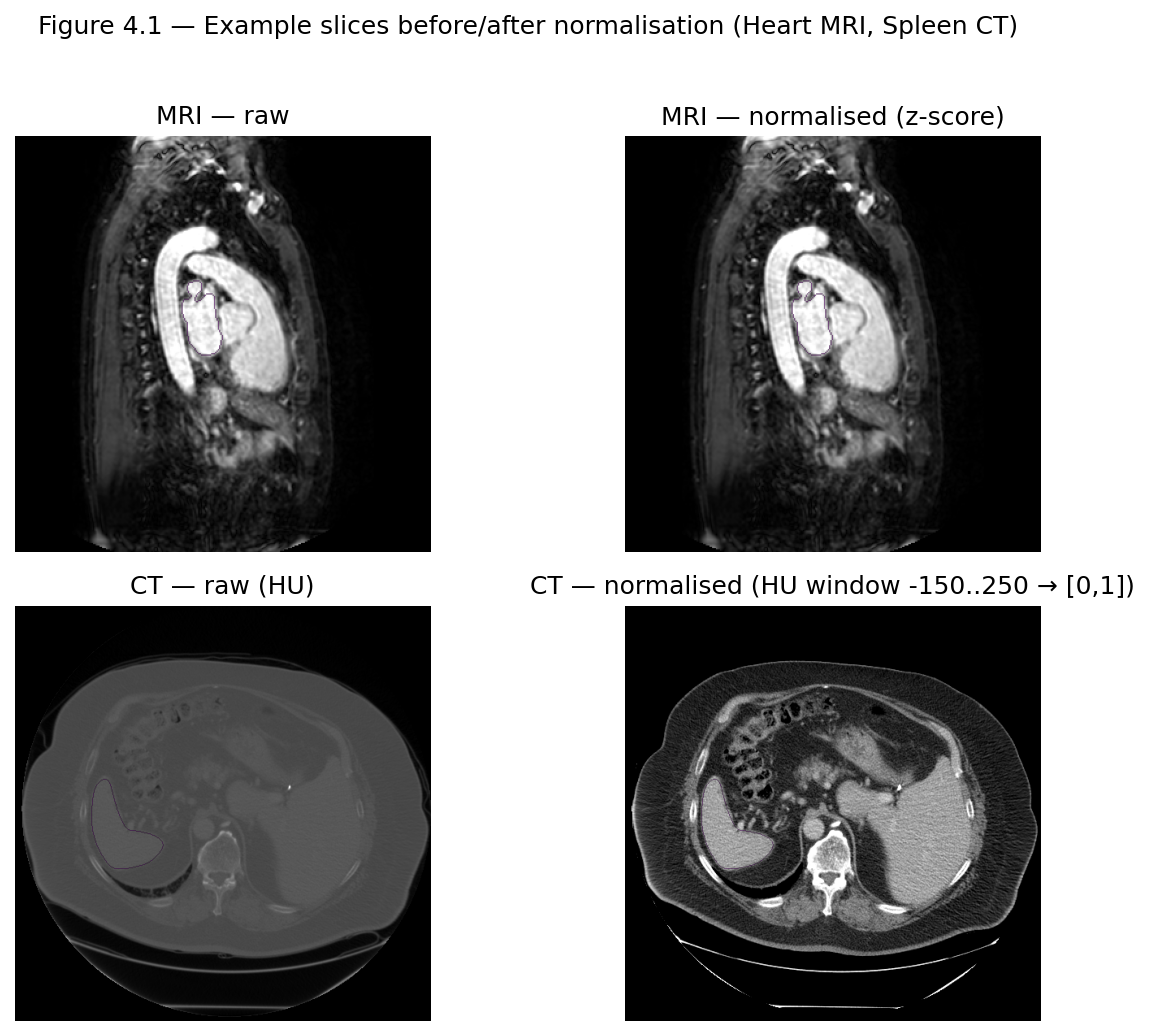

In [3]:
# For data analysis

HEART_ROOT  = "/home/htetaung/data/MSD/Task02_Heart"
SPLEEN_ROOT = "/home/htetaung/data/MSD/Task09_Spleen"


PREFERRED_WINDOWS_DIR = "/mnt/c/Users/Home/OneDrive/Desktop/Figures"


import os, glob, numpy as np, nibabel as nib, matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import binary_erosion

def _writable_dir(path: Path) -> Path:
    try:
        path.mkdir(parents=True, exist_ok=True)
        tmp = path / "__write_test__.tmp"
        with open(tmp, "wb") as f: f.write(b"ok")
        tmp.unlink()
        return path
    except Exception as e:
        raise OSError(f"Not writable: {path} ({e})")

def get_save_dir():
    if PREFERRED_WINDOWS_DIR:
        try:
            return _writable_dir(Path(PREFERRED_WINDOWS_DIR))
        except OSError as e:
            print(f"[Warn] {e}\n       Falling back to Linux home ~/Figures.")
    return _writable_dir(Path.home() / "Figures")

SAVE_DIR = get_save_dir()
print("Saving to:", SAVE_DIR)

def robust_percentile_clip(vol, lo=0.5, hi=99.5):
    v = vol[np.isfinite(vol)]
    if v.size == 0: 
        return vol
    p_lo, p_hi = np.percentile(v, [lo, hi])
    return np.clip(vol, p_lo, p_hi)

def zscore(vol, eps=1e-8):
    v = vol[np.isfinite(vol)]
    m, s = (float(v.mean()), float(v.std())) if v.size else (0.0, 1.0)
    return (vol - m) / (s + eps)

def ct_clip_scale(vol, lo=-150, hi=250, eps=1e-8):
    vol = np.clip(vol, lo, hi)
    return (vol - lo) / (hi - lo + eps)

def choose_slice_index(img3d, lbl3d=None):
    z = img3d.shape[2]
    if lbl3d is not None and lbl3d.shape == img3d.shape:
        areas = np.array([np.count_nonzero(lbl3d[..., k]) for k in range(z)])
        if areas.max() > 0:
            return int(areas.argmax())
    return z // 2

def edge_overlay(mask2d):
    m = mask2d.astype(bool)
    return m ^ binary_erosion(m, iterations=1)

def first_pair(root):
    img_tr = os.path.join(root, "imagesTr")
    lbl_tr = os.path.join(root, "labelsTr")
    img_ts = os.path.join(root, "imagesTs")

    imgs = sorted(glob.glob(os.path.join(img_tr, "*.nii*"))) or \
           sorted(glob.glob(os.path.join(img_ts, "*.nii*")))
    if not imgs:
        raise FileNotFoundError(f"No images found under {img_tr} or {img_ts}")

    img_path = imgs[0]
    base = os.path.basename(img_path)
    lbl_path = os.path.join(lbl_tr, base)
    if not os.path.exists(lbl_path):
        lbls = sorted(glob.glob(os.path.join(lbl_tr, "*.nii*")))
        lbl_path = lbls[0] if lbls else None
    return img_path, lbl_path

def load_3d(path):
    arr = nib.load(path).get_fdata()
    if arr.ndim == 4:
        arr = arr[..., 0]
    return arr.astype(np.float32)

# Resolve sample pairs
mri_img_path, mri_lbl_path = first_pair(HEART_ROOT)
ct_img_path,  ct_lbl_path  = first_pair(SPLEEN_ROOT)
print("Heart (MRI) image:", mri_img_path)
print("Heart (MRI) label:", mri_lbl_path)
print("Spleen (CT) image:", ct_img_path)
print("Spleen (CT) label:", ct_lbl_path)

# Load and normalise
mri_img = load_3d(mri_img_path);  mri_lbl = load_3d(mri_lbl_path) if (mri_lbl_path and os.path.exists(mri_lbl_path)) else None
ct_img  = load_3d(ct_img_path);   ct_lbl  = load_3d(ct_lbl_path)  if (ct_lbl_path  and os.path.exists(ct_lbl_path))  else None

mri_raw  = robust_percentile_clip(mri_img, 0.5, 99.5)
mri_norm = zscore(mri_raw)
ct_raw   = ct_img
ct_norm  = ct_clip_scale(ct_raw, lo=-150, hi=250)

# Pick slices (largest label area if available)
k_mri = choose_slice_index(mri_img, mri_lbl)
k_ct  = choose_slice_index(ct_img,  ct_lbl)

mri_raw_slice,  mri_norm_slice = np.rot90(mri_raw[..., k_mri]),  np.rot90(mri_norm[..., k_mri])
ct_raw_slice,   ct_norm_slice  = np.rot90(ct_raw[...,  k_ct]),   np.rot90(ct_norm[...,  k_ct])

mri_edges = np.rot90(edge_overlay(mri_lbl[..., k_mri])) if mri_lbl is not None else None
ct_edges  = np.rot90(edge_overlay(ct_lbl[...,  k_ct]))  if ct_lbl  is not None else None

# Plot & save
plt.figure(figsize=(9, 7), dpi=150)
ax = plt.subplot(2,2,1); ax.imshow(mri_raw_slice, cmap="gray"); 
if mri_edges is not None: ax.imshow(np.ma.masked_where(~mri_edges, mri_edges), alpha=0.6)
ax.set_title("MRI — raw"); ax.axis("off")

ax = plt.subplot(2,2,2); ax.imshow(mri_norm_slice, cmap="gray"); 
if mri_edges is not None: ax.imshow(np.ma.masked_where(~mri_edges, mri_edges), alpha=0.6)
ax.set_title("MRI — normalised (z-score)"); ax.axis("off")

ax = plt.subplot(2,2,3); ax.imshow(ct_raw_slice, cmap="gray"); 
if ct_edges is not None: ax.imshow(np.ma.masked_where(~ct_edges, ct_edges), alpha=0.6)
ax.set_title("CT — raw (HU)"); ax.axis("off")

ax = plt.subplot(2,2,4); ax.imshow(ct_norm_slice, cmap="gray"); 
if ct_edges is not None: ax.imshow(np.ma.masked_where(~ct_edges, ct_edges), alpha=0.6)
ax.set_title("CT — normalised (HU window -150..250 → [0,1])"); ax.axis("off")

plt.suptitle("Figure 4.1 — Example slices before/after normalisation (Heart MRI, Spleen CT)", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

save_path = str(SAVE_DIR / "Figure_4_1_prepost_normalisation.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print("Saved:", save_path)


In [5]:
# Table 4.1
SAVE_DIR = "/home/htetaung/data/Tables and figures"  


HEART_ROOT  = "/home/htetaung/data/MSD/Task02_Heart"
SPLEEN_ROOT = "/home/htetaung/data/MSD/Task09_Spleen"


import os, json, glob, pandas as pd
from pathlib import Path

# Create and test the WSL directory
p = Path(SAVE_DIR)
p.mkdir(parents=True, exist_ok=True)
# quick write test
try:
    testfile = p / "__writable__.tmp"
    with open(testfile, "wb") as f:
        f.write(b"ok")
    testfile.unlink()
except Exception as e:
    raise OSError(f"Cannot write to {p}: {e}")

def _read_dataset_json(root):
    """Read MSD dataset metadata; supports variant filenames."""
    for name in ["dataset.json", "dataset", "_dataset", "DATASET.json", "dataset.JSON"]:
        path = os.path.join(root, name)
        if os.path.exists(path):
            with open(path, "r", errors="ignore") as f:
                txt = f.read().strip()
                # Some MSD dumps are JSON even without .json extension
                try:
                    return json.loads(txt)
                except Exception as e:
                    raise ValueError(f"Failed to parse {path} as JSON: {e}")
    raise FileNotFoundError(f"No dataset.json-like file under {root}")

def _modality_str(dct):
    # MSD uses {"0":"CT"} or {"0":"MRI"} etc.
    if isinstance(dct, dict) and dct:
        return ", ".join(sorted(set(dct.values())))
    return str(dct)

def build_row(task_root, task_name, default_roi):
    dj = _read_dataset_json(task_root)
    modality = _modality_str(dj.get("modality", {}))
    # prefer metadata counts; fall back to file counts
    n_train = dj.get("numTraining")
    n_test  = dj.get("numTest")
    if n_train is None:
        n_train = len(glob.glob(os.path.join(task_root, "imagesTr", "*.nii*")))
    if n_test is None:
        n_test = len(glob.glob(os.path.join(task_root, "imagesTs", "*.nii*")))
    total = int(n_train) + int(n_test)
    desc  = dj.get("description") or dj.get("name") or task_name
    return {
        "Task": task_name,
        "Modality": modality,
        "Protocol / Acquisition": desc,
        "Target ROI": default_roi,
        "Total cases": total,
        "Train cases": int(n_train),
        "Test cases": int(n_test),
        "Source": "Medical Segmentation Decathlon [21]"
    }

rows = [
    build_row(HEART_ROOT,  "Heart (MRI)",  "Left atrium"),
    build_row(SPLEEN_ROOT, "Spleen (CT)",  "Spleen"),
]
df_41 = pd.DataFrame(rows, columns=[
    "Task","Modality","Protocol / Acquisition","Target ROI",
    "Total cases","Train cases","Test cases","Source"
])

tsv_path = str(p / "Table_4_1_dataset_summary.tsv")
csv_path = str(p / "Table_4_1_dataset_summary.csv")
df_41.to_csv(tsv_path, sep="\t", index=False)
df_41.to_csv(csv_path, index=False)
print("Saved:\n ", tsv_path, "\n ", csv_path)
print("\nPaste-friendly (tabs preserved):\n")
print(df_41.to_csv(sep="\t", index=False))

# FYI: Windows Explorer path to the same folder:
print("\nOpen in Windows Explorer:", r"\\wsl.localhost\Ubuntu\home\htetaung\data\Tables and figures")


Saved:
  /home/htetaung/data/Tables and figures/Table_4_1_dataset_summary.tsv 
  /home/htetaung/data/Tables and figures/Table_4_1_dataset_summary.csv

Paste-friendly (tabs preserved):

Task	Modality	Protocol / Acquisition	Target ROI	Total cases	Train cases	Test cases	Source
Heart (MRI)	MRI	Left atrium segmentation	Left atrium	30	20	10	Medical Segmentation Decathlon [21]
Spleen (CT)	CT	Spleen Segmentation	Spleen	61	41	20	Medical Segmentation Decathlon [21]


Open in Windows Explorer: \\wsl.localhost\Ubuntu\home\htetaung\data\Tables and figures


In [7]:
#Table 4.2, 4.3a amd 4.3b
#===================== USER CONFIG =====================
HEART_DIR_WIN  = r"\\wsl.localhost\Ubuntu\home\htetaung\projects\medssl_from_scratch\runs\v5_heart_20250828_122812"
SPLEEN_DIR_WIN = r"\\wsl.localhost\Ubuntu\home\htetaung\projects\medssl_from_scratch\runs\v5_spleen_20250828_122812"

SAVE_DIR = "/home/htetaung/data/Tables and figures"   # WSL path to save all tables
# =======================================================

import os, re, json, glob, time
from pathlib import Path
import numpy as np
import pandas as pd

# -------- path helpers --------
def win_unc_to_wsl(p: str) -> str:
    """
    Convert Windows UNC like '\\wsl.localhost\\Ubuntu\\home\\user\\...' to WSL '/home/user/...'
    Also converts backslashes to forward slashes.
    """
    if p is None: return None
    p2 = p.replace("\\", "/")
    anchor = "/wsl.localhost/Ubuntu/"
    if p2.startswith("//"):  # UNC form: //wsl.localhost/Ubuntu/home/...
        p2 = p2[1:]  # -> /wsl.localhost/Ubuntu/home/...
    if p2.startswith(anchor):
        p2 = p2[len("/wsl.localhost/Ubuntu"):]  # -> /home/...
    return p2

HEART_DIR  = win_unc_to_wsl(HEART_DIR_WIN)
SPLEEN_DIR = win_unc_to_wsl(SPLEEN_DIR_WIN)

print("Heart run dir (WSL): ", HEART_DIR)
print("Spleen run dir (WSL):", SPLEEN_DIR)

# ensure save dir exists & writable
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
try:
    with open(Path(SAVE_DIR)/"__writable__.tmp","wb") as f: f.write(b"ok")
    (Path(SAVE_DIR)/"__writable__.tmp").unlink()
except Exception as e:
    raise OSError(f"Cannot write to {SAVE_DIR}: {e}")

# -------- parser helpers --------
FLOAT = r"[-+]?\d*\.\d+|\d+"

def _candidate_files(run_dir: str, patterns):
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(run_dir, pat), recursive=True))
    # sort by mtime (latest last)
    files = sorted(files, key=lambda p: os.path.getmtime(p))
    return files

def parse_val_dice_series_from_dir(run_dir: str):
    """
    Search a run directory for validation-Dice time series.
    Returns list of (epoch_label, val_dice) sorted by appearance.
    """
    if not run_dir or not os.path.isdir(run_dir):
        raise FileNotFoundError(f"Run dir not found: {run_dir}")

    # Typical candidates
    candidates = _candidate_files(run_dir, patterns=[
        "**/train_log*.txt", "**/training*.log", "**/log*.txt", "**/*.log",
        "**/metrics.csv", "**/*history*.csv", "**/*scalars*.csv",
        "**/metrics.jsonl", "**/metrics.json", "**/*history*.jsonl", "**/*.jsonl"
    ])

    series = []
    used_file = None

    # 1) CSV candidates
    for fp in reversed(candidates):  # check newest first
        if not fp.lower().endswith(".csv"): continue
        try:
            df = pd.read_csv(fp)
            cols = {c.lower(): c for c in df.columns}
            # Look for any val dice column
            val_keys = [k for k in cols if ("dice" in k and "val" in k) or ("val" in k and "dsc" in k)]
            if not val_keys:
                continue
            vk = cols[val_keys[0]]
            # epoch column?
            ek = None
            for guess in ["epoch","epochs","step","iter","iteration","it"]:
                if guess in cols: ek = cols[guess]; break
            if ek is None:
                # fabricate monotonic index
                ep = list(range(len(df)))
            else:
                ep = df[ek].tolist()
            vals = df[vk].astype(float).tolist()
            series = list(zip(ep, vals))
            used_file = fp
            break
        except Exception:
            continue

    # 2) JSONL candidates
    if not series:
        for fp in reversed(candidates):
            if not fp.lower().endswith(".jsonl"): continue
            try:
                ep, vals = [], []
                with open(fp,"r",errors="ignore") as f:
                    for idx,line in enumerate(f):
                        line=line.strip()
                        if not (line.startswith("{") and line.endswith("}")): continue
                        obj = json.loads(line)
                        # try multiple keys
                        for k in ["val_dice","valDice","dice_val","val_dsc","val_dice_score"]:
                            if k in obj:
                                v = float(obj[k])
                                if -0.01 <= v <= 1.01:
                                    e = int(obj.get("epoch", idx))
                                    ep.append(e); vals.append(v)
                                break
                if vals:
                    series = list(zip(ep, vals))
                    used_file = fp
                    break
            except Exception:
                continue

    # 3) Text log candidates
    if not series:
        for fp in reversed(candidates):
            if not (fp.lower().endswith(".txt") or fp.lower().endswith(".log")): continue
            try:
                ep, vals = [], []
                with open(fp,"r",errors="ignore") as f:
                    for idx,line in enumerate(f):
                        L = line.strip()
                        # patterns that hint at val dice
                        if re.search(r"val[^a-zA-Z]*dice", L, flags=re.I) or \
                           (("Dice" in L or "dice" in L) and re.search(r"val|valid", L, flags=re.I)):
                            nums = [float(x) for x in re.findall(FLOAT, L)]
                            cand = [x for x in nums if -0.01 <= x <= 1.01]
                            if cand:
                                v = cand[-1]  # last float on the line
                                m = re.search(r"[Ee]poch[^0-9]*(\d+)", L)
                                e = int(m.group(1)) if m else len(ep)
                                ep.append(e); vals.append(v)
                if vals:
                    series = list(zip(ep, vals))
                    used_file = fp
                    break
            except Exception:
                continue

    if not series:
        print(f"[WARN] No validation-Dice series found in {run_dir}")
        return [], None

    # De-dup epochs keeping last occurrence
    by_epoch = {}
    for i,(e,v) in enumerate(series):
        by_epoch[e] = (i,v)
    out = [(e, by_epoch[e][1]) for e in sorted(by_epoch.keys(), key=lambda k: by_epoch[k][0])]
    print(f"[INFO] Validation-Dice parsed from: {used_file}")
    return out, used_file

def summarise_curve(curve):
    if not curve:
        return dict(epochs=np.nan, best_epoch=np.nan, best_val=np.nan, last10=np.nan, final=np.nan)
    vals = np.array([v for _,v in curve], dtype=float)
    epochs = len(vals)
    best_idx = int(np.nanargmax(vals))
    best_val = float(vals[best_idx])
    last10 = float(np.mean(vals[-10:])) if len(vals)>=10 else float(np.mean(vals))
    final  = float(vals[-1])
    best_epoch_label = curve[best_idx][0]
    return dict(epochs=epochs, best_epoch=best_epoch_label, best_val=best_val, last10=last10, final=final)

# ---- Table 4.2: training/validation summary from logs ----
def make_table_4_2(run_dir: str, task_label: str):
    curve, used = parse_val_dice_series_from_dir(run_dir)
    s = summarise_curve(curve)
    return {
        "Task": task_label,
        "Epochs": s["epochs"],
        "Best epoch": s["best_epoch"],
        "Best val Dice": (None if np.isnan(s["best_val"]) else f"{s['best_val']:.6f}"),
        "Last-10-epoch mean": (None if np.isnan(s["last10"]) else f"{s['last10']:.6f}"),
        "Final epoch val": (None if np.isnan(s["final"]) else f"{s['final']:.6f}"),
        "Log source": (used or "—")
    }

df_42 = pd.DataFrame([
    make_table_4_2(HEART_DIR,  "Heart (MRI)"),
    make_table_4_2(SPLEEN_DIR, "Spleen (CT)")
], columns=["Task","Epochs","Best epoch","Best val Dice","Last-10-epoch mean","Final epoch val","Log source"])

tsv42 = os.path.join(SAVE_DIR, "Table_4_2_v5_training_summary.tsv")
csv42 = os.path.join(SAVE_DIR, "Table_4_2_v5_training_summary.csv")
df_42.to_csv(tsv42, sep="\t", index=False)
df_42.to_csv(csv42, index=False)
print("\nSaved Table 4.2:\n ", tsv42, "\n ", csv42)
print("\n--- Table 4.2 (paste into Word; tabs preserved) ---\n")
print(df_42.drop(columns=["Log source"]).to_csv(sep="\t", index=False))

# ---- Tables 4.3a / 4.3b: patch-level eval ----
def find_eval_csv(run_dir: str):
    """
    Try common names for patch-level evaluation CSVs. Returns list of candidates (most recent last).
    Expected columns: case_id, patch_id, dice [, empty_pred] [, hd95]
    """
    patterns = [
        "**/*eval*patch*.csv", "**/*patch*eval*.csv", "**/*patch*metrics*.csv",
        "**/eval*patch*.csv", "**/validation*patch*.csv", "**/*patch_results*.csv",
        "**/eval*.csv", "**/validation*.csv"
    ]
    cands = _candidate_files(run_dir, patterns)
    return cands

def bootstrap_mean_ci(values, n_boot=4000, alpha=0.05, seed=42):
    if len(values)==0: return (np.nan,np.nan,np.nan)
    rng = np.random.default_rng(seed)
    vals = np.array(values, dtype=float)
    boots = rng.choice(vals, (n_boot, len(vals)), replace=True).mean(axis=1)
    mean = float(vals.mean())
    lo,hi = float(np.quantile(boots, alpha/2)), float(np.quantile(boots, 1-alpha/2))
    return mean, lo, hi

def make_43_tables(run_dir: str, task_label: str):
    eval_csvs = find_eval_csv(run_dir)
    used = eval_csvs[-1] if eval_csvs else None
    if not used:
        print(f"[WARN] No patch-level eval CSV found in {run_dir}")
        # skeleton tables
        t43a = pd.DataFrame([{
            "Task": task_label, "Set": "Validation/Test",
            "Aggregation": "per-patch (pooled)", "Mean Dice": np.nan, "SD": np.nan,
            "95% CI lower": np.nan, "95% CI upper": np.nan, "n cases": np.nan
        },{
            "Task": task_label, "Set": "Validation/Test",
            "Aggregation": "per-case (patch means)", "Mean Dice": np.nan, "SD": np.nan,
            "95% CI lower": np.nan, "95% CI upper": np.nan, "n cases": np.nan
        }])
        t43b = pd.DataFrame([{
            "Task": task_label, "Set": "Validation/Test",
            "Empty prediction rate (%)": np.nan, "Median HD95 (mm)": np.nan,
            "Notes": "Export patch-level eval CSV to populate"
        }])
        return t43a, t43b, None

    df = pd.read_csv(used)
    cols = {c.lower(): c for c in df.columns}
    def pick(*names):
        for n in names:
            if n in cols: return cols[n]
        return None

    dice_col   = pick("dice","dsc","dice_score","val_dice")
    case_col   = pick("case_id","case","subject","id")
    empty_col  = pick("empty_pred","empty","is_empty")
    hd_col     = pick("hd95","hd_95","hd")
    if dice_col is None or case_col is None:
        print(f"[WARN] CSV {used} missing required columns (need dice & case_id at minimum).")
        # skeleton
        return make_43_tables(run_dir, task_label)

    # per-patch pooled
    pp_vals = df[dice_col].dropna().astype(float).values
    pp_mean = float(np.mean(pp_vals)) if pp_vals.size else np.nan
    pp_sd   = float(np.std(pp_vals, ddof=1)) if pp_vals.size>1 else np.nan

    # per-case patch means
    per_case = df.groupby(case_col)[dice_col].mean().dropna().astype(float)
    pc_mean, pc_lo, pc_hi = bootstrap_mean_ci(per_case.values)
    pc_sd   = float(per_case.std(ddof=1)) if len(per_case)>1 else np.nan
    n_cases = int(per_case.shape[0])

    t43a = pd.DataFrame([
        {"Task": task_label, "Set": "Validation/Test", "Aggregation": "per-patch (pooled)",
         "Mean Dice": round(pp_mean,6) if not np.isnan(pp_mean) else np.nan,
         "SD": round(pp_sd,6) if not np.isnan(pp_sd) else np.nan,
         "95% CI lower": np.nan, "95% CI upper": np.nan, "n cases": n_cases},
        {"Task": task_label, "Set": "Validation/Test", "Aggregation": "per-case (patch means)",
         "Mean Dice": round(pc_mean,6) if not np.isnan(pc_mean) else np.nan,
         "SD": round(pc_sd,6) if not np.isnan(pc_sd) else np.nan,
         "95% CI lower": round(pc_lo,6) if not np.isnan(pc_lo) else np.nan,
         "95% CI upper": round(pc_hi,6) if not np.isnan(pc_hi) else np.nan,
         "n cases": n_cases}
    ])

    # diagnostics
    if empty_col and empty_col in df.columns:
        empty_rate = float(100.0 * df[empty_col].astype(int).mean())
    else:
        empty_rate = np.nan
    if hd_col and hd_col in df.columns:
        med_hd = float(df[hd_col].dropna().astype(float).median())
    else:
        med_hd = np.nan

    t43b = pd.DataFrame([{
        "Task": task_label, "Set": "Validation/Test",
        "Empty prediction rate (%)": round(empty_rate,2) if not np.isnan(empty_rate) else np.nan,
        "Median HD95 (mm)": round(med_hd,3) if not np.isnan(med_hd) else np.nan,
        "Notes": f"Source: {os.path.basename(used)} (HD95 more meaningful on full volumes)"
    }])

    print(f"[INFO] Patch-level eval parsed from: {used}")
    return t43a, t43b, used

# Heart + Spleen
t43a_h, t43b_h, src_h = make_43_tables(HEART_DIR,  "Heart (MRI)")
t43a_s, t43b_s, src_s = make_43_tables(SPLEEN_DIR, "Spleen (CT)")
df_43a = pd.concat([t43a_h, t43a_s], ignore_index=True)
df_43b = pd.concat([t43b_h, t43b_s], ignore_index=True)

# save all tables
tsv43a = os.path.join(SAVE_DIR, "Table_4_3a_patch_level_dice.tsv")
csv43a = os.path.join(SAVE_DIR, "Table_4_3a_patch_level_dice.csv")
df_43a.to_csv(tsv43a, sep="\t", index=False); df_43a.to_csv(csv43a, index=False)

tsv43b = os.path.join(SAVE_DIR, "Table_4_3b_diagnostics.tsv")
csv43b = os.path.join(SAVE_DIR, "Table_4_3b_diagnostics.csv")
df_43b.to_csv(tsv43b, sep="\t", index=False); df_43b.to_csv(csv43b, index=False)

print("\nSaved Table 4.3a:\n ", tsv43a, "\n ", csv43a)
print("Saved Table 4.3b:\n ", tsv43b, "\n ", csv43b)

print("\n--- Table 4.3a (paste into Word) ---\n")
print(df_43a.to_csv(sep="\t", index=False))
print("\n--- Table 4.3b (paste into Word) ---\n")
print(df_43b.to_csv(sep="\t", index=False))

print("\nOpen in Windows Explorer:", r"\\wsl.localhost\Ubuntu\home\htetaung\data\Tables and figures")



Heart run dir (WSL):  /home/htetaung/projects/medssl_from_scratch/runs/v5_heart_20250828_122812
Spleen run dir (WSL): /home/htetaung/projects/medssl_from_scratch/runs/v5_spleen_20250828_122812
[WARN] No validation-Dice series found in /home/htetaung/projects/medssl_from_scratch/runs/v5_heart_20250828_122812
[WARN] No validation-Dice series found in /home/htetaung/projects/medssl_from_scratch/runs/v5_spleen_20250828_122812

Saved Table 4.2:
  /home/htetaung/data/Tables and figures/Table_4_2_v5_training_summary.tsv 
  /home/htetaung/data/Tables and figures/Table_4_2_v5_training_summary.csv

--- Table 4.2 (paste into Word; tabs preserved) ---

Task	Epochs	Best epoch	Best val Dice	Last-10-epoch mean	Final epoch val
Heart (MRI)					
Spleen (CT)					

[WARN] No patch-level eval CSV found in /home/htetaung/projects/medssl_from_scratch/runs/v5_heart_20250828_122812
[WARN] No patch-level eval CSV found in /home/htetaung/projects/medssl_from_scratch/runs/v5_spleen_20250828_122812

Saved Table 4.

/tmp/ipykernel_2949/1621172843.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.04, 1, 0.98])


Saved Figure 4.10 to: /home/htetaung/data/Tables and figures/Figure_4_10_qualitative.png
Open from Windows: \\wsl.localhost\Ubuntu\home\htetaung\data\Tables and figures\Figure_4_10_qualitative.png


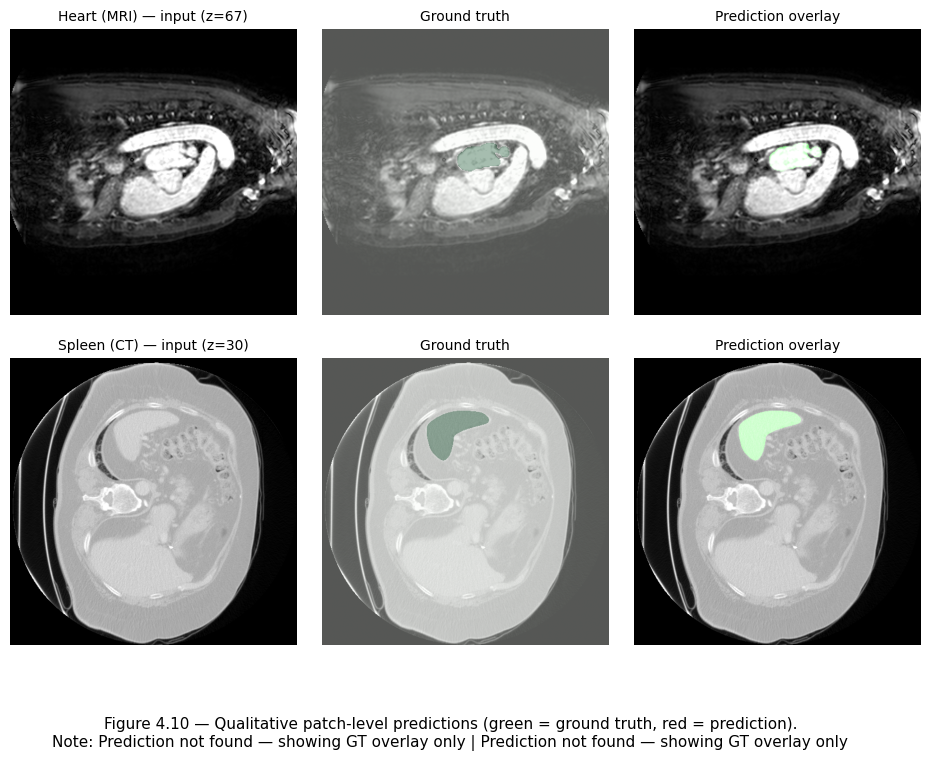

In [8]:
# ===================== USER PATHS =====================
SAVE_DIR = "/home/htetaung/data/Tables and figures"

HEART_IMG_DIR  = "/home/htetaung/data/MSD/Task02_Heart/imagesTr"
HEART_LBL_DIR  = "/home/htetaung/data/MSD/Task02_Heart/labelsTr"
SPLEEN_IMG_DIR = "/home/htetaung/data/MSD/Task09_Spleen/imagesTr"
SPLEEN_LBL_DIR = "/home/htetaung/data/MSD/Task09_Spleen/labelsTr"

HEART_RUN_DIR  = "/home/htetaung/projects/medssl_from_scratch/runs/v5_heart_20250828_122812"
SPLEEN_RUN_DIR = "/home/htetaung/projects/medssl_from_scratch/runs/v5_spleen_20250828_122812"

# Optional: if you want the cell to run inference when no saved predictions are found:
RUN_INFERENCE_IF_NEEDED = False  # <- set to True if you want on-the-fly inference
CHECKPOINT_PATH_HEART   = None   # e.g., "/home/.../checkpoints/best.pt"
CHECKPOINT_PATH_SPLEEN  = None   # e.g., "/home/.../checkpoints/best.pt"
# ======================================================

import os, glob, json, math
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

def load_nii(path):
    img = nib.load(path)
    arr = img.get_fdata().astype(np.float32)
    return arr, img.affine

def norm_mri(vol):
    v = np.clip(vol, np.percentile(vol, 1), np.percentile(vol, 99))
    m, s = v.mean(), v.std() + 1e-8
    return (v - m) / s

def norm_ct(vol):
    v = np.clip(vol, np.percentile(vol, 0.5), np.percentile(vol, 99.5))
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)
    return v

def pick_case(img_dir, lbl_dir):
    # choose a case that has a non-empty label
    for img_p in sorted(glob.glob(os.path.join(img_dir, "*.nii*"))):
        case_id = os.path.basename(img_p).split(".nii")[0]
        lbl_p = os.path.join(lbl_dir, case_id + ".nii.gz")
        if not os.path.exists(lbl_p):
            lbl_p = os.path.join(lbl_dir, case_id + ".nii")  # fallback
        if not os.path.exists(lbl_p):
            continue
        lbl, _ = load_nii(lbl_p)
        if np.count_nonzero(lbl) > 0:
            return img_p, lbl_p, case_id
    # fallback to first
    img_p = sorted(glob.glob(os.path.join(img_dir, "*.nii*")))[0]
    case_id = os.path.basename(img_p).split(".nii")[0]
    lbl_p = os.path.join(lbl_dir, case_id + ".nii.gz")
    return img_p, lbl_p, case_id

def center_foreground_slice(lbl, axis=2):
    # find a slice index through the thick of the foreground
    if lbl.ndim != 3: return 0
    if axis == 2:
        areas = (lbl>0).sum(axis=(0,1))
    elif axis == 1:
        areas = (lbl>0).sum(axis=(0,2))
    else:
        areas = (lbl>0).sum(axis=(1,2))
    if areas.max() == 0:
        return lbl.shape[axis]//2
    idx = int(np.argmax(areas))
    return idx

def find_saved_pred(run_dir, case_id):
    """
    Look for saved predicted masks or logits for this case.
    Accepts .nii(.gz) or .npy. Returns array or None.
    """
    pats = [
        f"**/*{case_id}*pred*.nii*", f"**/*pred*{case_id}*.nii*",
        f"**/*{case_id}*pred*.npy",  f"**/*pred*{case_id}*.npy"
    ]
    cands = []
    for p in pats:
        cands += glob.glob(os.path.join(run_dir, p), recursive=True)
    if not cands:
        return None
    cands = sorted(cands, key=os.path.getmtime)
    fp = cands[-1]
    try:
        if fp.endswith(".npy"):
            arr = np.load(fp)
        else:
            arr,_ = load_nii(fp)
        # if it's probability/logit, binarize at 0.5
        if arr.max() <= 1.0 and arr.min() >= 0.0:
            pred = (arr >= 0.5).astype(np.uint8)
        else:
            # logits? apply sigmoid then 0.5
            pred = (1/(1+np.exp(-arr)) >= 0.5).astype(np.uint8)
        return pred
    except Exception:
        return None

def run_quick_inference(case_img_path, modality="MRI", checkpoint_path=None):
    """
    Minimal placeholder for on-the-fly inference if you want it.
    You should replace the 'build_v5_model()' part with the exact model building
    function/class you use in your v5 notebook.
    """
    if not RUN_INFERENCE_IF_NEEDED:
        return None
    try:
        import torch
        # ---- TODO: replace this with your real model factory ----
        # from your_notebook_module import build_v5_model
        # model = build_v5_model().eval().cuda()
        # if checkpoint_path: model.load_state_dict(torch.load(checkpoint_path)["state_dict"])
        # ---------------------------------------------------------
        raise NotImplementedError("Plug your v5 model builder here.")
    except Exception as e:
        print(f"[INFO] Skipping on-the-fly inference: {e}")
        return None

def make_overlay(img2d, gt2d, pr2d, alpha=0.35):
    """
    Returns an RGB image with GT in green and prediction in red (overlaid on grayscale).
    """
    img = img2d
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    rgb = np.stack([img, img, img], axis=-1)
    gt = (gt2d>0).astype(np.float32)
    pr = (pr2d>0).astype(np.float32)

    # green for GT
    rgb[...,1] = np.clip(rgb[...,1] + alpha*gt, 0, 1)
    # red for prediction
    rgb[...,0] = np.clip(rgb[...,0] + alpha*pr, 0, 1)
    return rgb

def render_case(img_p, lbl_p, run_dir, modality, title_prefix):
    vol, _ = load_nii(img_p)
    lbl, _ = load_nii(lbl_p)
    if modality.upper()=="MRI":
        vol_n = norm_mri(vol)
    else:
        vol_n = norm_ct(vol)

    # find a good axial slice
    z = center_foreground_slice(lbl, axis=2)
    img_z = vol_n[:,:,z]
    gt_z  = lbl[:,:,z]

    # try to find saved prediction
    case_id = os.path.basename(img_p).split(".nii")[0]
    pred_vol = find_saved_pred(run_dir, case_id)
    if pred_vol is None:
        pred_vol = run_quick_inference(img_p, modality=modality,
                                       checkpoint_path=None)  # fill in if using
    if pred_vol is None:
        # fallback: blank prediction to at least render GT vs input
        pr_z = np.zeros_like(gt_z, dtype=np.uint8)
        note = "Prediction not found — showing GT overlay only"
    else:
        # handle shape mismatch (e.g., prediction resampled)
        if pred_vol.shape != lbl.shape:
            # simple center-crop/pad to match (best effort for visual)
            shp = lbl.shape
            pv  = pred_vol
            pad = [(0,0)]*3
            for d in range(3):
                if pv.shape[d] < shp[d]:
                    extra = shp[d]-pv.shape[d]
                    pad[d] = (extra//2, extra - extra//2)
            pv = np.pad(pv, pad, mode="constant")
            pred_vol = pv[:shp[0], :shp[1], :shp[2]]
        pr_z = pred_vol[:,:,z]
        note = None

    ov = make_overlay(img_z, gt_z, pr_z)
    return img_z, gt_z, pr_z, ov, z, note

# ---- pick cases ----
heart_img, heart_lbl, heart_id = pick_case(HEART_IMG_DIR, HEART_LBL_DIR)
spleen_img, spleen_lbl, spleen_id = pick_case(SPLEEN_IMG_DIR, SPLEEN_LBL_DIR)

# ---- render both tasks ----
h_img, h_gt, h_pr, h_ov, h_z, h_note = render_case(heart_img, heart_lbl, HEART_RUN_DIR, "MRI", "Heart")
s_img, s_gt, s_pr, s_ov, s_z, s_note = render_case(spleen_img, spleen_lbl, SPLEEN_RUN_DIR, "CT", "Spleen")

# ---- plot collage ----
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 3, wspace=0.02, hspace=0.15)

# Heart row
ax = fig.add_subplot(gs[0,0]); ax.imshow(h_img, cmap="gray"); ax.set_title(f"Heart (MRI) — input (z={h_z})", fontsize=10); ax.axis("off")
ax = fig.add_subplot(gs[0,1]); ax.imshow(h_img, cmap="gray"); ax.imshow((h_gt>0).astype(float), alpha=0.35, cmap="Greens"); ax.set_title("Ground truth", fontsize=10); ax.axis("off")
ax = fig.add_subplot(gs[0,2]); ax.imshow(h_ov); ax.set_title("Prediction overlay", fontsize=10); ax.axis("off")

# Spleen row
ax = fig.add_subplot(gs[1,0]); ax.imshow(s_img, cmap="gray"); ax.set_title(f"Spleen (CT) — input (z={s_z})", fontsize=10); ax.axis("off")
ax = fig.add_subplot(gs[1,1]); ax.imshow(s_img, cmap="gray"); ax.imshow((s_gt>0).astype(float), alpha=0.35, cmap="Greens"); ax.set_title("Ground truth", fontsize=10); ax.axis("off")
ax = fig.add_subplot(gs[1,2]); ax.imshow(s_ov); ax.set_title("Prediction overlay", fontsize=10); ax.axis("off")

cap = "Figure 4.10 — Qualitative patch-level predictions (green = ground truth, red = prediction)."
if h_note or s_note:
    cap += "\nNote: " + " | ".join([x for x in [h_note, s_note] if x])

fig.suptitle(cap, fontsize=11, y=0.02)
plt.tight_layout(rect=[0, 0.04, 1, 0.98])

out_path = os.path.join(SAVE_DIR, "Figure_4_10_qualitative.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print("Saved Figure 4.10 to:", out_path)
print("Open from Windows:", r"\\wsl.localhost\Ubuntu\home\htetaung\data\Tables and figures\Figure_4_10_qualitative.png")


In [11]:
# ===================== USER CONFIG =====================
HEART_RUN_WIN  = r"\\wsl.localhost\Ubuntu\home\htetaung\projects\medssl_from_scratch\runs\v5_heart_20250828_122812"
SPLEEN_RUN_WIN = r"\\wsl.localhost\Ubuntu\home\htetaung\projects\medssl_from_scratch\runs\v5_spleen_20250828_122812"

# Your notebook printed: "Summary csv -> /home/.../runs/v5_summary.csv"
SUMMARY_CSV = "/home/htetaung/projects/medssl_from_scratch/runs/v5_summary.csv"

SAVE_DIR = "/home/htetaung/data/Tables and figures"   # WSL path to save the table
OUT_BASENAME = "Table_4_4_validation_snapshot"        # file stem for .tsv/.csv
# =======================================================

import os, re, glob
import pandas as pd
from pathlib import Path

def win_unc_to_wsl(p: str) -> str:
    if p is None: return None
    p2 = p.replace("\\", "/")
    if p2.startswith("//"):  # UNC -> single leading slash
        p2 = p2[1:]
    anchor = "/wsl.localhost/Ubuntu"
    if p2.startswith(anchor):
        p2 = p2[len(anchor):]  # keep leading slash for /home/...
    return p2

HEART_RUN  = win_unc_to_wsl(HEART_RUN_WIN)
SPLEEN_RUN = win_unc_to_wsl(SPLEEN_RUN_WIN)
runs = [("Heart (MRI)", HEART_RUN), ("Spleen (CT)", SPLEEN_RUN)]

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

# ---- 1) Load summary CSV (val_best_dice, best_epoch, best_threshold) ----
summary_rows = {}
if os.path.exists(SUMMARY_CSV):
    try:
        df_sum = pd.read_csv(SUMMARY_CSV, dtype=str)
        for _, row in df_sum.iterrows():
            rec = {c.lower(): str(row[c]) if pd.notna(row[c]) else "" for c in df_sum.columns}
            outd = rec.get("out_dir","") or rec.get("outdir","") or rec.get("run_dir","")
            task = rec.get("task","").lower()
            if outd: summary_rows[outd] = rec
            if task: summary_rows[task] = rec
        print(f"[INFO] Loaded summary CSV with {len(df_sum)} rows:", SUMMARY_CSV)
    except Exception as e:
        print(f"[WARN] Could not parse {SUMMARY_CSV}: {e}")
else:
    print(f"[WARN] Summary CSV not found at {SUMMARY_CSV}")

def as_float(x):
    try: return float(x)
    except: return None
def as_int(x):
    try: return int(float(x))
    except: return None

# ---- 2) Optionally parse logs for "Best threshold = X, Dice = Y" (we only keep X) ----
def best_threshold_from_logs(run_dir: str):
    if not run_dir or not os.path.isdir(run_dir): return None
    files = []
    for pat in ("**/*.txt","**/*.log"):
        files += glob.glob(os.path.join(run_dir, pat), recursive=True)
    files = sorted(files, key=os.path.getmtime, reverse=True)
    rx = re.compile(r"Best\s+threshold\s*=\s*([0-9]*\.?[0-9]+)", re.I)
    for fp in files:
        try:
            with open(fp,"r",errors="ignore") as f:
                for line in f:
                    m = rx.search(line)
                    if m:
                        return float(m.group(1))
        except: 
            continue
    return None

# ---- 3) Build the table (no Dice@thr, no run dir) ----
rows = []
for label, rdir in runs:
    key1 = rdir
    key2 = label.split()[0].lower()  # 'heart' or 'spleen'
    rec = summary_rows.get(key1) or summary_rows.get(key2) or {}

    epochs         = as_int(rec.get("epochs"))
    best_epoch     = as_int(rec.get("best_epoch"))
    val_best_dice  = as_float(rec.get("val_best_dice"))
    thr_csv        = as_float(rec.get("best_threshold"))
    thr_log        = best_threshold_from_logs(rdir)
    best_thr       = thr_log if thr_log is not None else thr_csv

    rows.append({
        "Task": label,
        "Epochs": epochs if epochs is not None else "",
        "Best epoch (by valDice)": best_epoch if best_epoch is not None else "",
        "Best valDice (soft)": (f"{val_best_dice:.6f}" if val_best_dice is not None else ""),
        "Best threshold": (f"{best_thr:.2f}" if best_thr is not None else "")
    })

df = pd.DataFrame(rows, columns=[
    "Task","Epochs","Best epoch (by valDice)","Best valDice (soft)","Best threshold"
])

# ---- 4) Save (TSV for Word; CSV optional) ----
tsv_path = os.path.join(SAVE_DIR, OUT_BASENAME + ".tsv")
csv_path = os.path.join(SAVE_DIR, OUT_BASENAME + ".csv")
df.to_csv(tsv_path, sep="\t", index=False)
df.to_csv(csv_path, index=False)
print("Saved:\n ", tsv_path, "\n ", csv_path)
print("\nPaste-friendly (tabs preserved):\n")
print(df.to_csv(sep="\t", index=False))
print("\nOpen in Windows:", r"\\wsl.localhost\Ubuntu\home\htetaung\data\Tables and figures")


[INFO] Loaded summary CSV with 22 rows: /home/htetaung/projects/medssl_from_scratch/runs/v5_summary.csv
Saved:
  /home/htetaung/data/Tables and figures/Table_4_4_validation_snapshot.tsv 
  /home/htetaung/data/Tables and figures/Table_4_4_validation_snapshot.csv

Paste-friendly (tabs preserved):

Task	Epochs	Best epoch (by valDice)	Best valDice (soft)	Best threshold
Heart (MRI)	150	150	0.781986	0.75
Spleen (CT)	150	123	0.742469	0.50


Open in Windows: \\wsl.localhost\Ubuntu\home\htetaung\data\Tables and figures
